# 1. Baseline Models for Real Estate Price Prediction – Evaluation and Insights

This notebook focuses on building and comparing baseline machine learning models to predict real estate prices using tabular property data.

We aim to evaluate the strengths and limitations of different regression approaches, such as:

- **Linear Regression**: as a simple interpretable baseline.
- **Random Forest**: a powerful ensemble method for handling non-linearities.
- **Reduced Random Forest**: using only the top features to assess the impact of dimensionality reduction.

For each model, we:

- Train on the available features (`bedroomCount`, `surface`, `postCode`, etc.).
- Predict the target variable: **raw price** in euros.
- Evaluate performance using MAE, RMSE, and R<sup>2</sup> metrics.
- Visualize residuals and prediction errors using 3 diagnostic plots:
  - Residuals vs Predicted
  - Residual Distribution
  - Predicted vs Actual

>  Key insight: The raw price target leads to high error due to extreme variance and lack of normalization. This will be addressed in future notebooks using `price_per_m<sup>2</sup>`, segmentation, and better feature engineering.

This notebook serves as a foundation for improving model robustness and exploring advanced ML techniques in future steps.

# Load dataset and clean
- Step 1 – Drop columns with too many missing value
- Step 2 – Keep only rows with at least 70% non-missing values
- Step 3 – Remove outliers based on key numerical columns

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# === Load dataset ===
df = pd.read_csv("../data/immoweb_real_estate.csv")

# === Step 1 – Drop columns with too many missing values ===
missing_threshold = 0.5

# Total number of columns before cleaning
initial_col_count = df.shape[1]

# Identify columns to drop (those with >50% missing values)
cols_to_drop = df.columns[df.isnull().mean() > missing_threshold]
dropped_col_count = len(cols_to_drop)

# Drop columns
df_cleaned = df.drop(columns=cols_to_drop)

# Count remaining columns
remaining_col_count = df_cleaned.shape[1]

# Display column cleaning summary
print("\n=== Drop columns with a missing threashold = 0.5 ===")
print(f"Initial number of columns: {initial_col_count}")
print(f"Number of columns dropped (>50% missing): {dropped_col_count}")
print(f"Remaining columns: {remaining_col_count}")

print("\nColumns dropped:")
for col in cols_to_drop:
    print(f"  • {col}")

# === Step 2 – Keep only rows with at least 70% non-missing values ===
min_required = int(df_cleaned.shape[1] * 0.7)  # Minimum non-null values required per row
before_shape = df_cleaned.shape

# Drop rows below threshold
df_cleaned = df_cleaned.dropna(thresh=min_required)
after_shape = df_cleaned.shape

# Display only rows with at least 70% non-missing values
print("\n=== Keep only rows with at least 70% non-missing values ===")
print(f"Threshold: keep rows with ≥70% non-missing values (at least {min_required} non-null columns)")
print(f"Rows before cleaning: {before_shape[0]}")
print(f"Rows after cleaning:  {after_shape[0]}")
print(f"Rows removed:         {before_shape[0] - after_shape[0]}")

# === Step 3 – Remove outliers based on key numerical columns ===
df = df_cleaned.copy()

# Apply filters to remove extreme outliers
df_no_outliers = df[
    (df["price"] >= 50000) & (df["price"] <= 1_200_000) &
    (df["habitableSurface"] >= 15) & (df["habitableSurface"] <= 500) &
    (df["bedroomCount"] >= 0) & (df["bedroomCount"] <= 10) &
    (df["bathroomCount"] >= 0) & (df["bathroomCount"] <= 5) &
    (df["toiletCount"] >= 0) & (df["toiletCount"] <= 5) &
    (df["buildingConstructionYear"] >= 1850) & (df["buildingConstructionYear"] <= 2025)
]

# Display final Cleaning Summary without outliers
print("\n=== Final Cleaning Summary (No outliers) ===")
print("Outlier filtering applied on selected columns.")
print(f"Rows before outlier removal: {df.shape[0]}")
print(f"Rows after outlier removal:  {df_no_outliers.shape[0]}")
print(f"Rows removed as outliers:    {df.shape[0] - df_no_outliers.shape[0]}")

# === Export cleaned dataset ===
df_no_outliers.to_csv("../data/immoweb_real_estate_cleaned_dataset.csv", index=False)
print("Cleaned dataset saved to: '../data/immoweb_real_estate_cleaned_dataset.csv'")

# Save as Excel
excel_path = "../data/immoweb_real_estate_ml_ready_sample10.xlsx"
df_no_outliers.head(10).to_excel(excel_path, index=False)
print(f"Excel sample file saved to: {excel_path}")



=== Drop columns with a missing threashold = 0.5 ===
Initial number of columns: 53
Number of columns dropped (>50% missing): 31
Remaining columns: 22

Columns dropped:
  • roomCount
  • monthlyCost
  • hasAttic
  • hasBasement
  • hasDressingRoom
  • diningRoomSurface
  • hasDiningRoom
  • floorCount
  • streetFacadeWidth
  • hasLift
  • hasHeatPump
  • hasPhotovoltaicPanels
  • hasThermicPanels
  • kitchenSurface
  • landSurface
  • livingRoomSurface
  • hasBalcony
  • hasGarden
  • gardenSurface
  • gardenOrientation
  • parkingCountIndoor
  • parkingCountOutdoor
  • hasAirConditioning
  • hasArmoredDoor
  • hasVisiophone
  • hasOffice
  • hasSwimmingPool
  • hasFireplace
  • terraceSurface
  • terraceOrientation
  • accessibleDisabledPeople

=== Keep only rows with at least 70% non-missing values ===
Threshold: keep rows with ≥70% non-missing values (at least 15 non-null columns)
Rows before cleaning: 80368
Rows after cleaning:  70125
Rows removed:         10243

=== Final Cleaning

## Load and Explore the Dataset

- Load dataset
- df.head(), df.info(), df.describe()
- Visual summary: distributions, correlations, missing values

In [2]:
# Load and Explore the Dataset

# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Load the cleaned dataset
df = pd.read_csv("../data/immoweb_real_estate_cleaned_dataset.csv")

# Display basic structure
print("Dataset loaded successfully!")
print("Shape:", df.shape)

# Display the first rows
df.head()



Dataset loaded successfully!
Shape: (30189, 22)


,Unnamed: 0,id,url,type,subtype,bedroomCount,bathroomCount,province,locality,postCode,...,buildingConstructionYear,facedeCount,floodZoneType,heatingType,kitchenType,hasLivingRoom,toiletCount,hasTerrace,epcScore,price
0,0,20661494.0,https://www.immoweb.be/en/classified/apartment...,APARTMENT,APARTMENT,2.0,1.0,Brussels,Etterbeek,1040,...,2004.0,1.0,NON_FLOOD_ZONE,GAS,SEMI_EQUIPPED,True,1.0,True,C,399000.0
1,1,20647642.0,https://www.immoweb.be/en/classified/house/for...,HOUSE,HOUSE,4.0,2.0,Brussels,Etterbeek,1040,...,1910.0,2.0,NON_FLOOD_ZONE,FUELOIL,INSTALLED,True,3.0,True,E,895000.0
2,2,20644816.0,https://www.immoweb.be/en/classified/apartment...,APARTMENT,APARTMENT,2.0,1.0,Brussels,Etterbeek,1040,...,1970.0,2.0,NaN,FUELOIL,HYPER_EQUIPPED,True,1.0,True,F,465000.0
3,3,20659813.0,https://www.immoweb.be/en/classified/apartment...,APARTMENT,APARTMENT,2.0,2.0,Brussels,Bruxelles,1040,...,2018.0,NaN,RECOGNIZED_FLOOD_ZONE,GAS,HYPER_EQUIPPED,True,2.0,True,B,590000.0
4,4,20633249.0,https://www.immoweb.be/en/classified/flat-stud...,APARTMENT,FLAT_STUDIO,1.0,1.0,Brussels,Etterbeek,1040,...,1906.0,2.0,NON_FLOOD_ZONE,GAS,INSTALLED,NaN,1.0,NaN,E,289000.0


In [3]:
# Check column types and non-null counts
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30189 entries, 0 to 30188
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                30189 non-null  int64  
 1   id                        30189 non-null  float64
 2   url                       30189 non-null  object 
 3   type                      30189 non-null  object 
 4   subtype                   30189 non-null  object 
 5   bedroomCount              30189 non-null  float64
 6   bathroomCount             30189 non-null  float64
 7   province                  30189 non-null  object 
 8   locality                  30189 non-null  object 
 9   postCode                  30189 non-null  int64  
 10  habitableSurface          30189 non-null  float64
 11  buildingCondition         25376 non-null  object 
 12  buildingConstructionYear  30189 non-null  float64
 13  facedeCount               22224 non-null  float64
 14  floodZ

In [4]:
# Summary statistics for numerical columns
df.describe()



,Unnamed: 0,id,bedroomCount,bathroomCount,postCode,habitableSurface,buildingConstructionYear,facedeCount,toiletCount,price
count,30189.000000,3.018900e+04,30189.000000,30189.000000,30189.000000,30189.000000,30189.000000,22224.000000,30189.000000,3.018900e+04
mean,191679.542681,1.986363e+07,2.844778,1.275266,4909.526748,152.700454,1978.788102,2.820509,1.643811,3.946684e+05
std,114782.544023,2.409397e+06,1.196765,0.566340,3141.451520,79.611575,39.454688,1.021503,0.759004,2.024915e+05
min,0.000000,1.882546e+06,1.000000,1.000000,1000.000000,15.000000,1850.000000,1.000000,1.000000,5.000000e+04
25%,175809.000000,2.040835e+07,2.000000,1.000000,2100.000000,93.000000,1957.000000,2.000000,1.000000,2.550000e+05
50%,226620.000000,2.054793e+07,3.000000,1.000000,3900.000000,135.000000,1980.000000,3.000000,2.000000,3.490000e+05
75%,254669.000000,2.062074e+07,3.000000,1.000000,8420.000000,191.000000,2016.000000,4.000000,2.000000,4.750000e+05
max,446550.000000,2.066439e+07,10.000000,5.000000,9992.000000,500.000000,2025.000000,86.000000,5.000000,1.200000e+06


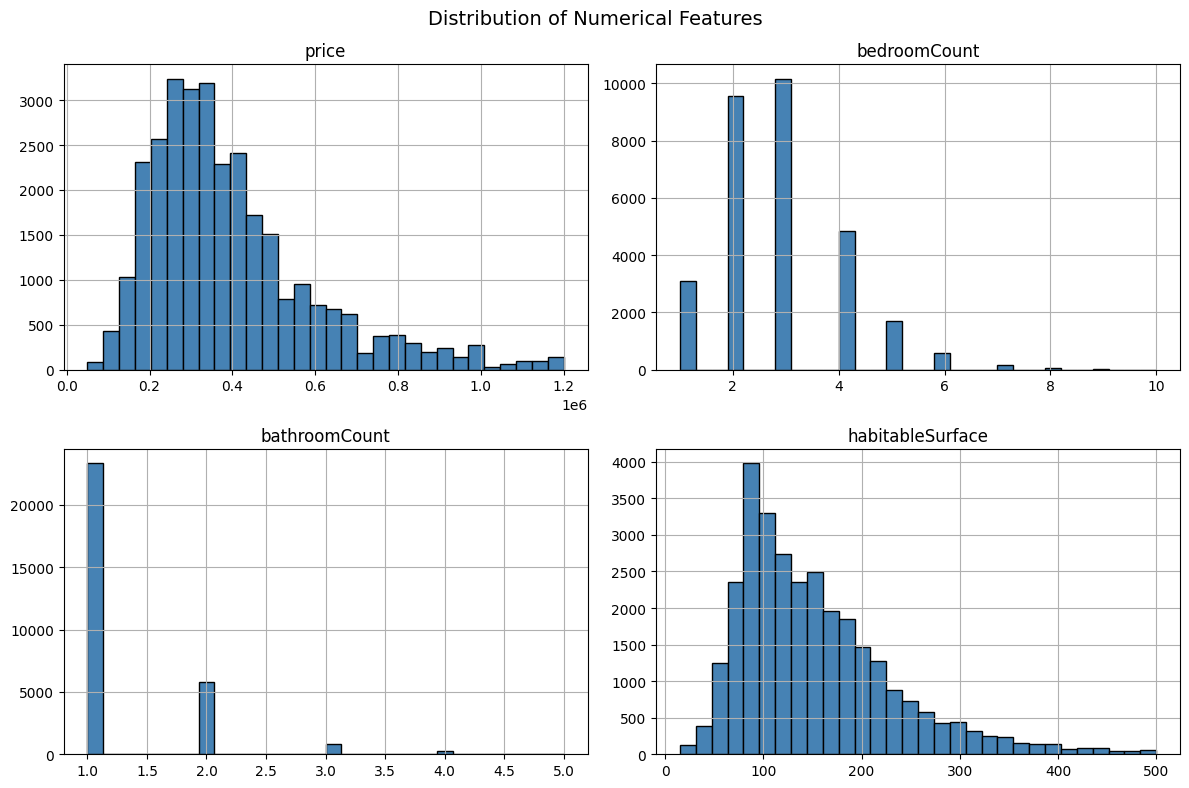

In [5]:
# Plot distributions of key numerical variables
numerical_cols = ['price', 'bedroomCount', 'bathroomCount', 'habitableSurface']
df[numerical_cols].hist(figsize=(12, 8), bins=30, color="steelblue", edgecolor="black")
plt.suptitle("Distribution of Numerical Features", fontsize=14)
plt.tight_layout()
plt.show()

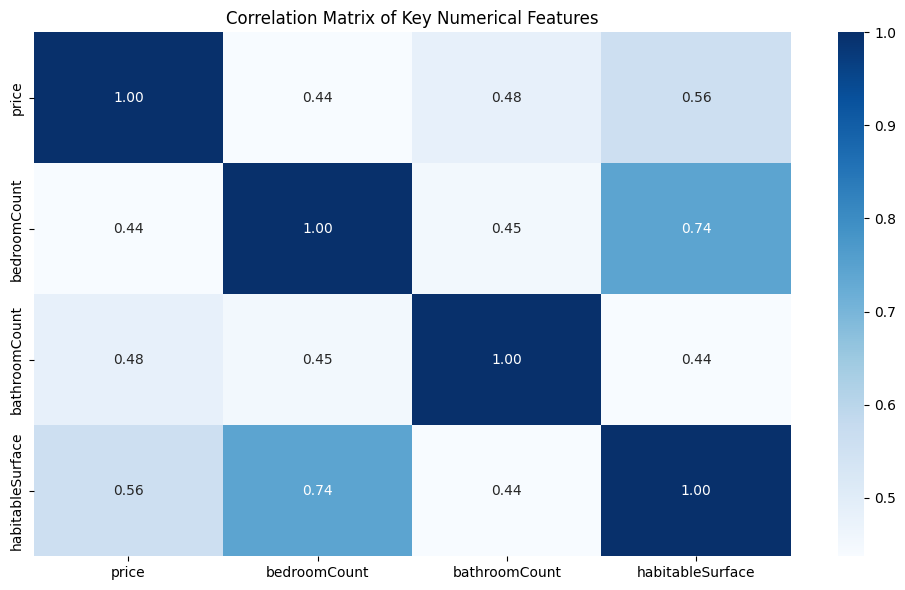

In [6]:
# Correlation heatmap for numerical variables
plt.figure(figsize=(10, 6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Matrix of Key Numerical Features")
plt.tight_layout()
plt.show()

# Visualize missing values using missingno

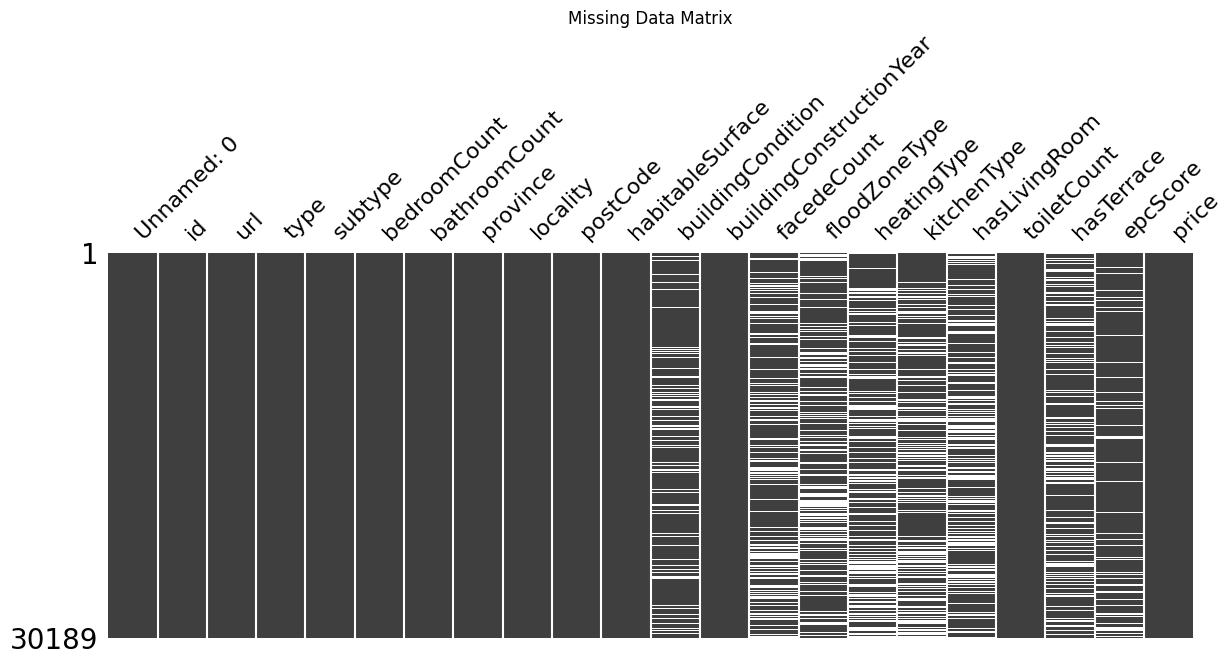

In [7]:
# Load the cleaned dataset
df = pd.read_csv("../data/immoweb_real_estate_cleaned_dataset.csv")

# Visualize missing values using missingno
msno.matrix(df, figsize=(14, 5), sparkline=False)
plt.title("Missing Data Matrix")
plt.show()

# Show Quantitative and Qualitative Variables 

In [8]:
import pandas as pd

# Read the cleaned dataset
df = pd.read_csv("../data/immoweb_real_estate_cleaned_dataset.csv")

# Vérification rapide
print("Dataset loaded with shape:", df.shape)

# Separate columns by data type
quantitative_cols = df.select_dtypes(include=["int", "float"]).columns.tolist()
qualitative_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Display results
print("Quantitative Variables (Numerical):")
for col in quantitative_cols:
    print(f" - {col}")

print("\n Qualitative Variables (Categorical):")
for col in qualitative_cols:
    print(f" - {col}")

Dataset loaded with shape: (30189, 22)
Quantitative Variables (Numerical):
 - Unnamed: 0
 - id
 - bedroomCount
 - bathroomCount
 - postCode
 - habitableSurface
 - buildingConstructionYear
 - facedeCount
 - toiletCount
 - price

 Qualitative Variables (Categorical):
 - url
 - type
 - subtype
 - province
 - locality
 - buildingCondition
 - floodZoneType
 - heatingType
 - kitchenType
 - hasLivingRoom
 - hasTerrace
 - epcScore


# Preparing the Dataset for Machine Learning

Before training any supervised or unsupervised model, we must clean, transform, and encode the raw dataset.

## Objectives:
- Remove non-informative columns (IDs, URLs)
- Handle missing values
- Encode categorical variables
- Convert boolean columns to numerical
- Select useful features for modeling
- Save a clean dataset for reuse

This step ensures the data is consistent, numerical, and machine-readable.

In [9]:
import os
import shutil
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 1. Load dataset
df = pd.read_csv("../data/immoweb_real_estate_cleaned_dataset.csv")
print(f"Dataset shape before cleaning: {df.shape}")

# 2. Drop non-informative columns
df.drop(columns=["Unnamed: 0", "id", "url"], inplace=True)

# 3. Convert booleans (from string to int)
bool_cols = ['hasLivingRoom', 'hasTerrace']
for col in bool_cols:
    df[col] = df[col].astype(str).str.lower().map({'true': 1, 'false': 0})
    df[col] = df[col].fillna(0).astype(int)

# 4. Identify categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in bool_cols]

# 5. Handle missing values for numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('price')  # Exclude target from imputing

# 6. Drop rows with missing target
df = df.dropna(subset=['price'])

# 7. Apply preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
], remainder="passthrough")

# Fit and transform
X_prepared = preprocessor.fit_transform(df.drop(columns=["price"]))
target = df["price"].values

# 8. Reconstruct into DataFrame
# Get feature names
num_features = numeric_cols
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_cols)
other_features = [col for col in df.columns if col not in (categorical_cols + numeric_cols + ["price"])]

final_columns = list(num_features) + list(cat_features) + other_features

# Combine features and target

df_model = pd.DataFrame(X_prepared, columns=final_columns)
df_model["price"] = target

# 9. Save final dataset (csv)

# Define the folder path
folder_path = "../data/ML"

# Delete the folder if it exists
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Deleted existing folder: {folder_path}")

# Recreate the folder
os.makedirs(folder_path)
print(f"Recreated folder: {folder_path}")

output_path = "../data/ML/immoweb_real_estate_ml_ready.csv"
df_model.to_csv(output_path, index=False)
print(f"Cleaned dataset saved to: {output_path}")
print(f"Final shape: {df_model.shape}")

# Save as Excel
excel_path = "../data/ML/immoweb_real_estate_ml_ready_sample10.xlsx"
df_model.head(10).to_excel(excel_path, index=False)
print(f"Excel sample file saved to: {excel_path}")

# === Apply the preprocessor to the full dataset ===
from sklearn.compose import ColumnTransformer

X_processed = preprocessor.transform(df.drop(columns=["price"]))

# Convert the transformed array into a DataFrame with proper column names
X_transformed_df = pd.DataFrame(X_processed, columns=final_columns)

# Add the target column back if needed
X_transformed_df["price"] = df["price"].reset_index(drop=True)

# === Show top 10 records of ML dataset ===
print("\n=== Top 10 records after preprocessing ===")
print(X_transformed_df.head(10).to_string(index=False))

Dataset shape before cleaning: (30189, 22)
Deleted existing folder: ../data/ML
Recreated folder: ../data/ML
Cleaned dataset saved to: ../data/ML/immoweb_real_estate_ml_ready.csv
Final shape: (30189, 3259)
Excel sample file saved to: ../data/ML/immoweb_real_estate_ml_ready_sample10.xlsx

=== Top 10 records after preprocessing ===
 bedroomCount  bathroomCount  postCode  habitableSurface  buildingConstructionYear  facedeCount  toiletCount  type_APARTMENT  type_HOUSE  subtype_APARTMENT  subtype_APARTMENT_BLOCK  subtype_BUNGALOW  subtype_CHALET  subtype_COUNTRY_COTTAGE  subtype_DUPLEX  subtype_EXCEPTIONAL_PROPERTY  subtype_FARMHOUSE  subtype_FLAT_STUDIO  subtype_GROUND_FLOOR  subtype_HOUSE  subtype_KOT  subtype_LOFT  subtype_MANOR_HOUSE  subtype_MANSION  subtype_MIXED_USE_BUILDING  subtype_OTHER_PROPERTY  subtype_PENTHOUSE  subtype_SERVICE_FLAT  subtype_TOWN_HOUSE  subtype_TRIPLEX  subtype_VILLA  province_Antwerp  province_Brussels  province_East Flanders  province_Flemish Brabant  province

In [10]:
# Display the first rows
df_model.head()

,bedroomCount,bathroomCount,postCode,habitableSurface,buildingConstructionYear,facedeCount,toiletCount,type_APARTMENT,type_HOUSE,subtype_APARTMENT,...,epcScore_C,epcScore_C_B,epcScore_D,epcScore_E,epcScore_F,epcScore_G,epcScore_nan,hasLivingRoom,hasTerrace,price
0,2.0,1.0,1040.0,100.0,2004.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,399000.0
1,4.0,2.0,1040.0,270.0,1910.0,2.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,895000.0
2,2.0,1.0,1040.0,87.0,1970.0,2.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,465000.0
3,2.0,2.0,1040.0,104.0,2018.0,3.0,2.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,590000.0
4,1.0,1.0,1040.0,71.0,1906.0,2.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,289000.0


# Create CSV file for model metrics

In [11]:
import pandas as pd
import os

# Define path
csv_folder = "../data/ML"
csv_path = os.path.join(csv_folder, "model_metrics.csv")

# Ensure the directory exists
os.makedirs(csv_folder, exist_ok=True)

# Ensure results folder exists
os.makedirs("../results", exist_ok=True)

# Delete file if it exists
if os.path.exists(csv_path):
    os.remove(csv_path)
    print(f"Existing CSV deleted: {csv_path}")

# Create fresh CSV with headers only
columns = ["model", "mae", "rmse", "r2"]
empty_df = pd.DataFrame(columns=columns)
empty_df.to_csv(csv_path, index=False)
print(f"New empty CSV created: {csv_path}")


New empty CSV created: ../data/ML\model_metrics.csv


In [12]:
def log_model_metrics(model_name, mae, rmse, r2, csv_path="../data/ML/model_metrics.csv"):
    new_entry = pd.DataFrame([{
        "model": model_name,
        "mae": round(mae, 2),
        "rmse": round(rmse, 2),
        "r2": round(r2, 4)
    }])
    new_entry.to_csv(csv_path, mode="a", index=False, header=False)
    print(f"Metrics logged for: {model_name}")

In [13]:
def display_model_log_and_best_model(csv_path="../data/ML/model_metrics.csv"):
    """
    Display the model evaluation summary sorted by R² and highlight the best model.
    """
    try:
        df = pd.read_csv(csv_path)
        df = df.drop_duplicates()

        # Sort by R² descending
        df = df.sort_values(by="r2", ascending=False).reset_index(drop=True)

        # Mark the best model
        df["best"] = ""
        if not df.empty:
            df.at[0, "best"] = "✓"

        # Display the DataFrame
        print("\n>>> Model Evaluation Summary (sorted by R²):")
        from IPython.display import display
        display(df)

        print(f"\n👉 Best model based on R²: {df.loc[0, 'model']}")

    except FileNotFoundError:
        print(f"File not found: {csv_path}")
    except Exception as e:
        print(f"An error occurred: {e}")



## Full Random Forest Feature Importance – All Features

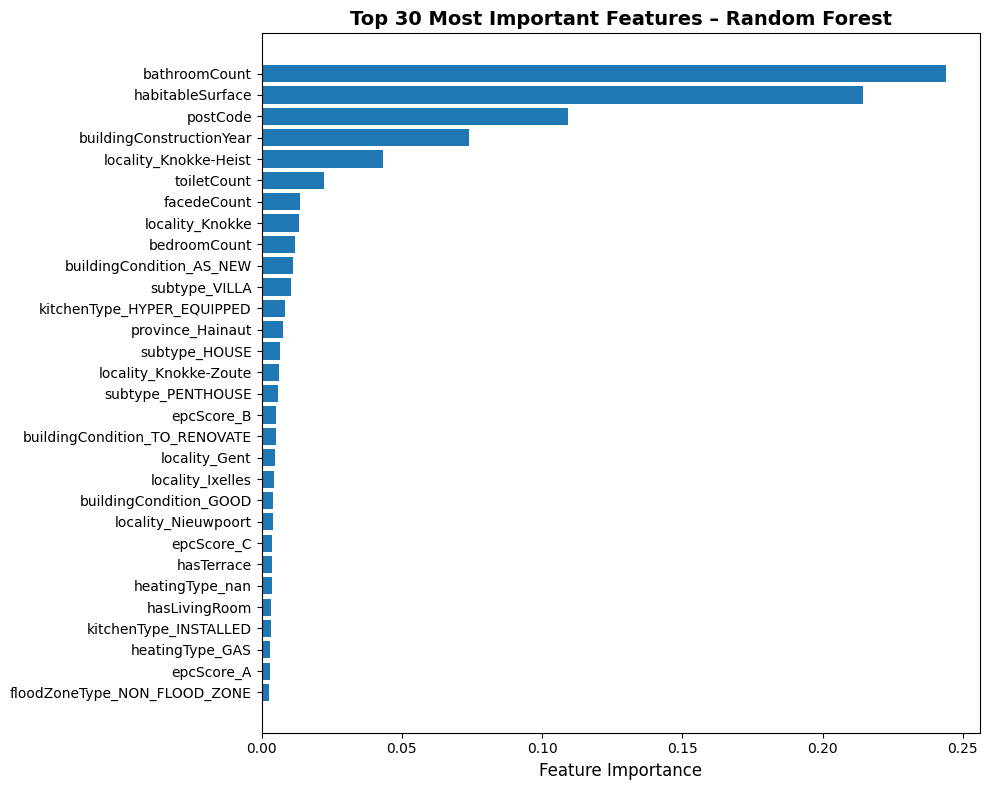

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("../data/ML/immoweb_real_estate_ml_ready.csv")

# Drop rows with missing target (price)
df_model = df.dropna(subset=["price"])

# Separate target and features
X = df_model.drop(columns=["price"])
y = df_model["price"]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train a Random Forest Regressor on all features
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

# Extract feature importances
importances = model.feature_importances_
feature_names = X.columns

# Sort features by importance (descending)
sorted_idx = np.argsort(importances)[::-1]
top_n = 30  # number of top features to display

# Plot top N features
plt.figure(figsize=(10, 8))
plt.barh(range(top_n), importances[sorted_idx][:top_n][::-1], align='center')
plt.yticks(range(top_n), feature_names[sorted_idx][:top_n][::-1])
plt.title("Top 30 Most Important Features – Random Forest", fontsize=14, weight='bold')
plt.xlabel("Feature Importance", fontsize=12)
plt.tight_layout()
plt.show()


## StandardScaler + Lasso

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Drop rows with missing target (price)
df_model = df.dropna(subset=["price"])

# Separate target and features
X = df_model.drop(columns=["price"])
y = df_model["price"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Build pipeline: standardize + LassoCV with parallel processing
lasso_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LassoCV(cv=5, n_jobs=-1, max_iter=10000, random_state=42))
])
lasso_pipeline.fit(X_train, y_train)

# Get feature names and coefficients
feature_names = X.columns
lasso_coefs = lasso_pipeline.named_steps["model"].coef_

# Convert to DataFrame
lasso_importance = pd.DataFrame({
    "Feature": feature_names,
    "Lasso Coefficient": np.abs(lasso_coefs)  # take absolute value
})
lasso_importance = lasso_importance.sort_values("Lasso Coefficient", ascending=False)

# Plot top N features
top_n = 30
plt.figure(figsize=(10, 8))
plt.barh(lasso_importance["Feature"][:top_n][::-1], 
         lasso_importance["Lasso Coefficient"][:top_n][::-1])
plt.title("Top 30 Most Important Features – Lasso Regression (Parallelized)", fontsize=14, weight="bold")
plt.xlabel("Absolute Coefficient Value", fontsize=12)
plt.tight_layout()
plt.show()


# 3. Supervised Learning

## 3.1 Regression (e.g., predicting property price)
- **Models**:
  - Linear Regression
  - Random Forest Regressor
- **Evaluation**:
  - MAE, RMSE, R<sup>2</sup>
- **Visualizations**:
  - Scatter plot (actual vs predicted)
  - Residual distribution


In [ ]:
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import root_mean_squared_error

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Evaluation:")
    print(f"  MAE:  {mae:,.2f} €")
    print(f"  RMSE: {rmse:,.2f} €")
    print(f"  R²:   {r2:.4f}")
    print("-" * 40)
    log_model_metrics(model_name, mae, rmse, r2)
    return y_pred, y_true - y_pred

# Load dataset
df = pd.read_csv("../data/ML/immoweb_real_estate_ml_ready.csv")

# Drop rows with missing values
df = df.dropna()

# Separate features and target
X = df.drop(columns=["price"])
y = df["price"]

# === Remove low variance features (e.g., one-hot dummies rarely activated) ===
selector = VarianceThreshold(threshold=0.01)  # supprime colonnes trop stables
X_reduced_array = selector.fit_transform(X)
X_reduced = pd.DataFrame(X_reduced_array, columns=X.columns[selector.get_support()])
# ==============================================================================

print(f"Initial shape: {X.shape}, Reduced shape: {X_reduced.shape}")

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_reduced_array, y, test_size=0.2, random_state=42)

# Train models on all features
lr_model_all = LinearRegression()
rf_model_all = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

lr_model_all.fit(X_train, y_train)
rf_model_all.fit(X_train, y_train)

# Predictions
y_pred_lr_all = lr_model_all.predict(X_test)
y_pred_rf_all = rf_model_all.predict(X_test)


# Evaluate full models
y_pred_lr_all, residuals_lr_all = evaluate_model(y_test, y_pred_lr_all, "Linear Regression (All Features)")
y_pred_rf_all, residuals_rf_all = evaluate_model(y_test, y_pred_rf_all, "Random Forest (All Features)")

# Select top 10 important features from Random Forest
feature_importances = pd.DataFrame({
    "feature": X_reduced.columns,
    "importance": rf_model_all.feature_importances_
}).sort_values(by="importance", ascending=False)

top_features = feature_importances.head(10)["feature"].tolist()

# Reduced dataset
X_top = X_reduced[top_features]
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Train reduced models
lr_model_top = LinearRegression()
rf_model_top = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

lr_model_top.fit(X_train_top, y_train_top)
rf_model_top.fit(X_train_top, y_train_top)

# Predictions with top features
y_pred_lr_top = lr_model_top.predict(X_test_top)
y_pred_rf_top = rf_model_top.predict(X_test_top)

# Evaluate reduced models
y_pred_lr_top, residuals_lr_top = evaluate_model(y_test_top, y_pred_lr_top, "Linear Regression (Top Features)")
y_pred_rf_top, residuals_rf_top = evaluate_model(y_test_top, y_pred_rf_top, "Random Forest (Top Features)")

# Display model evaluation summary
display_model_log_and_best_model()



Initial shape: (30189, 3258), Reduced shape: (30189, 65)
Linear Regression (All Features) Evaluation:
  MAE:  85,510.11 €
  RMSE: 121,149.58 €
  R²:   0.6366
----------------------------------------
Metrics logged for: Linear Regression (All Features)
Random Forest (All Features) Evaluation:
  MAE:  65,705.67 €
  RMSE: 98,940.13 €
  R²:   0.7576
----------------------------------------
Metrics logged for: Random Forest (All Features)
Linear Regression (Top Features) Evaluation:
  MAE:  96,534.10 €
  RMSE: 136,104.16 €
  R²:   0.5413
----------------------------------------
Metrics logged for: Linear Regression (Top Features)
Random Forest (Top Features) Evaluation:
  MAE:  67,309.43 €
  RMSE: 101,408.12 €
  R²:   0.7454
----------------------------------------
Metrics logged for: Random Forest (Top Features)

>>> Model Evaluation Summary (sorted by R²):


,model,mae,rmse,r2,best
0,Random Forest (All Features),65705.67,98940.13,0.7576,✓
1,Random Forest (Top Features),67309.43,101408.12,0.7454,
2,Linear Regression (All Features),85510.11,121149.58,0.6366,
3,Linear Regression (Top Features),96534.10,136104.16,0.5413,



👉 Best model based on R²: Random Forest (All Features)


### Model Evaluation Summary & Interpretation

After preprocessing and one-hot encoding, the dataset had:

- **Initial shape**: (30189 rows, 3258 features)  
- **Reduced shape** (after selecting top features): (30189 rows, 65 features)


### Metrics Explained

- **MAE (Mean Absolute Error)**  
  Measures the average absolute difference between predicted and actual prices.  
  → **Lower is better**. Ideal = **&euro;0**.

- **RMSE (Root Mean Squared Error)**  
  Penalizes large errors more than MAE. More sensitive to outliers.  
  → **Lower is better**. Ideal = **&euro;0**.

- **R<sup>2</sup> (R-squared or Coefficient of Determination)**  
  Represents the proportion of variance in the target variable explained by the model.  
  → **Higher is better**. Ideal = **1.0** (100%).



### Recommended Next Steps

- Fine-tune **Random Forest** or explore **gradient boosting models** (e.g., **XGBoost**, **LightGBM**, **CatBoost**) for potential improvements.
- Apply **hyperparameter tuning** using `GridSearchCV`, `RandomizedSearchCV`, or **Optuna**.
- Use **feature selection** to reduce dimensionality and speed up training.
- Validate the model on **external or live datasets** to assess generalization performance.


# Linear Regression (All Features) — Prediction vs Residual Analysis 

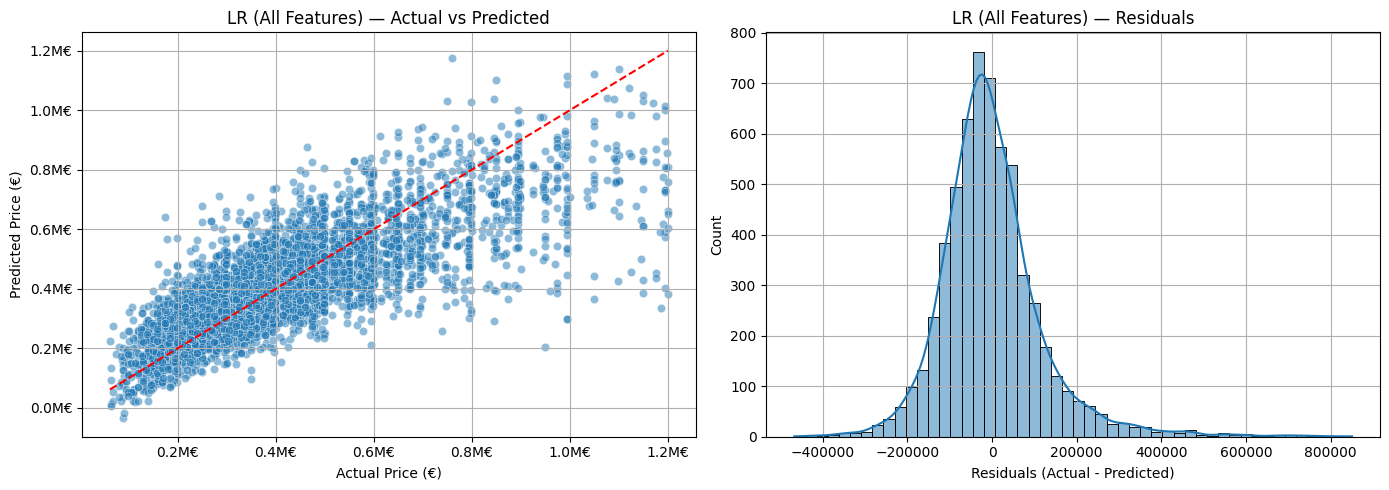

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Format currency in millions
million_formatter = FuncFormatter(lambda x, _: f'{x / 1_000_000:.1f}M€')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Actual vs Predicted
sns.scatterplot(x=y_test, y=y_pred_lr_all, alpha=0.5, ax=axes[0])
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
axes[0].set_title("LR (All Features) — Actual vs Predicted")
axes[0].set_xlabel("Actual Price (€)")
axes[0].set_ylabel("Predicted Price (€)")
axes[0].xaxis.set_major_formatter(million_formatter)
axes[0].yaxis.set_major_formatter(million_formatter)
axes[0].grid(True)

# Right: Residuals
sns.histplot(residuals_lr_all, bins=50, kde=True, ax=axes[1])
axes[1].set_title("LR (All Features) — Residuals")
axes[1].set_xlabel("Residuals (Actual - Predicted)")
axes[1].grid(True)

plt.tight_layout()
plt.show()



## Linear Regression (All Features) — Prediction vs Residual Analysis

### Interpretation

**Left Plot: Actual vs Predicted**
- This scatter plot shows the relationship between actual prices (x-axis) and predicted prices (y-axis).
- The red dashed line represents the ideal case (perfect predictions where actual = predicted).
- Points are reasonably aligned with the diagonal, but significant dispersion exists, especially for higher-priced properties (>&euro;600K).
- This indicates the Linear Regression model struggles to accurately capture the full range of price variability, especially in the upper range.

**Right Plot: Residuals Distribution**
- Residuals (actual - predicted) are centered around zero, which suggests no strong systematic bias.
- The distribution is fairly symmetric and bell-shaped, but with heavy tails. Some predictions are off by more than ±&euro;400K.
- The presence of such outliers indicates that linear models may oversimplify relationships in the data.

### Conclusion
The Linear Regression model using all features achieves a reasonable performance (R<sup>2</sup> ≈ 0.64), but fails to fully model the non-linear complexity of real estate pricing. While residuals are mostly centered, prediction errors are notably larger for expensive properties, suggesting a more flexible model—such as Random Forest or Gradient Boosting—would better capture the underlying patterns.


# Linear Regression with Top Features — Prediction Quality & Error Analysis

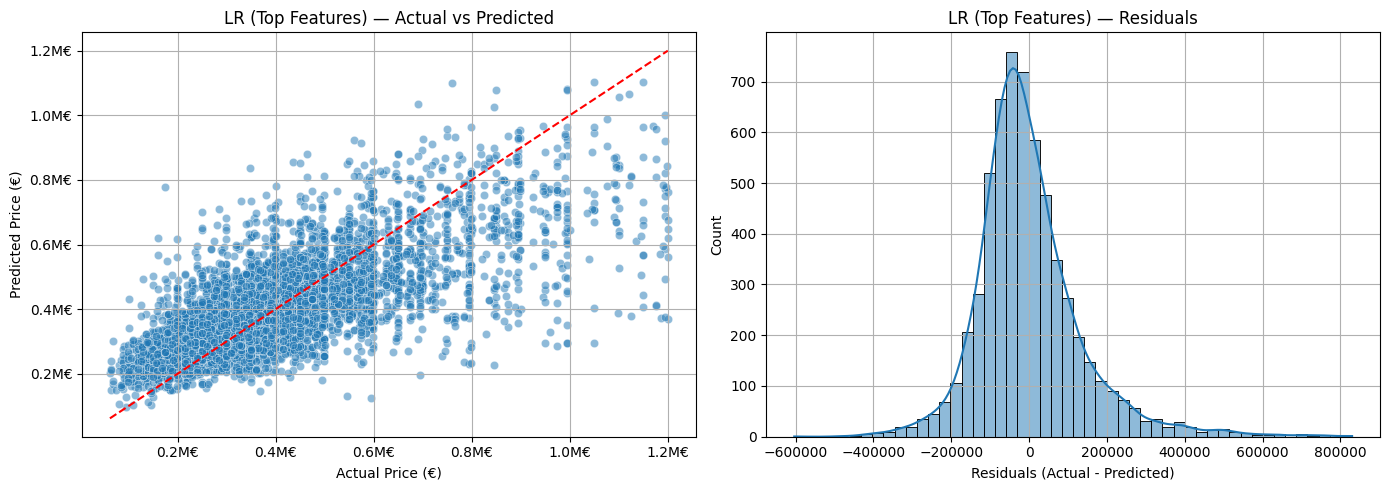

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Formatter pour l’axe en millions €
million_formatter = FuncFormatter(lambda x, _: f'{x / 1_000_000:.1f}M€')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
sns.scatterplot(x=y_test_top, y=y_pred_lr_top, alpha=0.5, ax=axes[0])
axes[0].plot([y_test_top.min(), y_test_top.max()], [y_test_top.min(), y_test_top.max()], '--', color='red')
axes[0].set_title("LR (Top Features) — Actual vs Predicted")
axes[0].set_xlabel("Actual Price (€)")
axes[0].set_ylabel("Predicted Price (€)")
axes[0].xaxis.set_major_formatter(million_formatter)
axes[0].yaxis.set_major_formatter(million_formatter)
axes[0].grid(True)

# Histogram of residuals
sns.histplot(residuals_lr_top, bins=50, kde=True, ax=axes[1])
axes[1].set_title("LR (Top Features) — Residuals")
axes[1].set_xlabel("Residuals (Actual - Predicted)")
axes[1].grid(True)

plt.tight_layout()
plt.show()


## Linear Regression (Top Features) — Prediction vs Residual Analysis

### Interpretation

**Left Plot: Actual vs Predicted**
- This scatter plot shows the predicted prices versus the actual prices using only the top 65 features.
- The red dashed line represents perfect predictions. A strong spread around the line is visible, particularly for properties priced above &euro;600K.
- Compared to the full-feature model, the alignment to the ideal line is looser, indicating a decrease in model accuracy due to reduced feature space.

**Right Plot: Residuals Distribution**
- The residuals remain centered around zero, which is good, but the spread is wider than with the full-feature model.
- A heavier tail suggests more frequent large errors in predictions.
- This pattern confirms the loss of information caused by reducing input dimensions, leading to underfitting in some segments.

#### Conclusion
The linear regression model with top features simplifies the dataset but at the cost of predictive power. The lower R<sup>2</sup> score (~0.54) reflects a reduced ability to explain the variance in prices. While this model is lighter and faster, it sacrifices too much accuracy for interpretability. An advanced non-linear model may perform better even with fewer features.


# Random Forest with All Features — Performance & Error Distribution


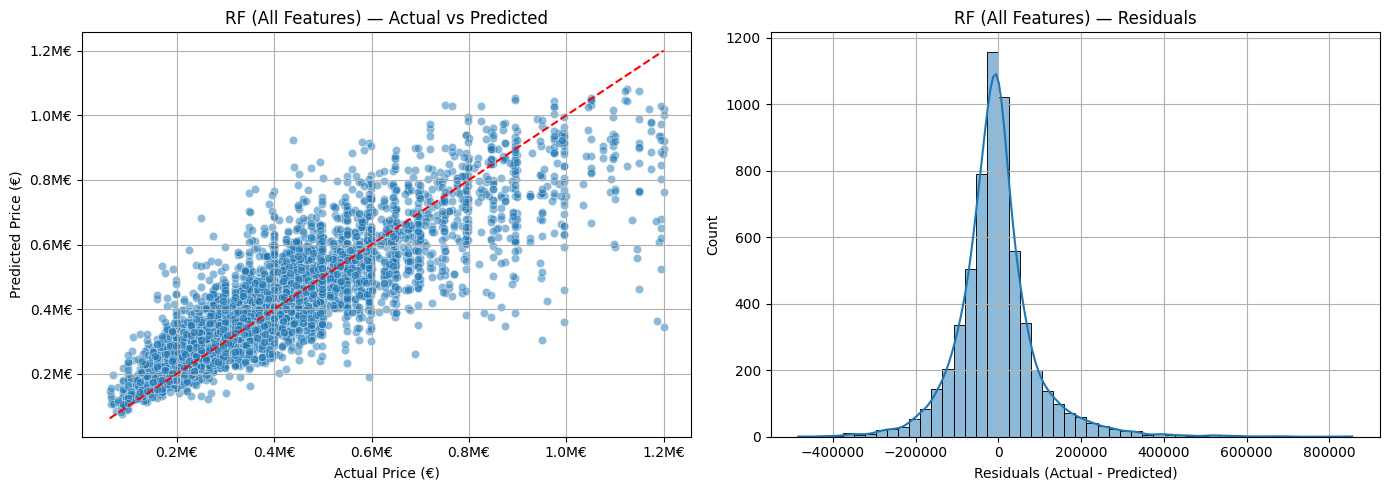

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Format des axes en millions d’euros
million_formatter = FuncFormatter(lambda x, _: f'{x / 1_000_000:.1f}M€')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Actual vs Predicted
sns.scatterplot(x=y_test, y=y_pred_rf_all, alpha=0.5, ax=axes[0])
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
axes[0].set_title("RF (All Features) — Actual vs Predicted")
axes[0].set_xlabel("Actual Price (€)")
axes[0].set_ylabel("Predicted Price (€)")
axes[0].xaxis.set_major_formatter(million_formatter)
axes[0].yaxis.set_major_formatter(million_formatter)
axes[0].grid(True)

# Residuals histogram
sns.histplot(residuals_rf_all, bins=50, kde=True, ax=axes[1])
axes[1].set_title("RF (All Features) — Residuals")
axes[1].set_xlabel("Residuals (Actual - Predicted)")
axes[1].grid(True)

plt.tight_layout()
plt.show()


## Random Forest (All Features) — Prediction vs Residual Analysis

### Interpretation

**Left Plot: Actual vs Predicted**
- This scatter plot compares the predicted prices from the Random Forest model to the actual prices.
- The predicted values are tightly clustered along the red diagonal, especially for properties priced under &euro;600K, indicating strong model performance in this range.
- However, for high-end properties (above &euro;800K), the model tends to underpredict, revealing a limitation in capturing complex patterns in the upper market range.

**Right Plot: Residuals Distribution**
- The residuals are centered around zero and display a tight, symmetric distribution.
- Compared to Linear Regression, the Random Forest model generates fewer large errors, as seen from the higher and narrower peak.
- The slight right skew suggests occasional underestimation of high prices, consistent with the scatter plot.

#### Conclusion
The Random Forest model with all features achieves strong predictive performance and low residual variance. Its non-linear structure captures complex relationships better than linear models. The tight residual distribution and alignment in prediction validate its suitability for structured tabular real estate data.


# Random Forest with Top Features — Prediction Accuracy & Residual Analysis


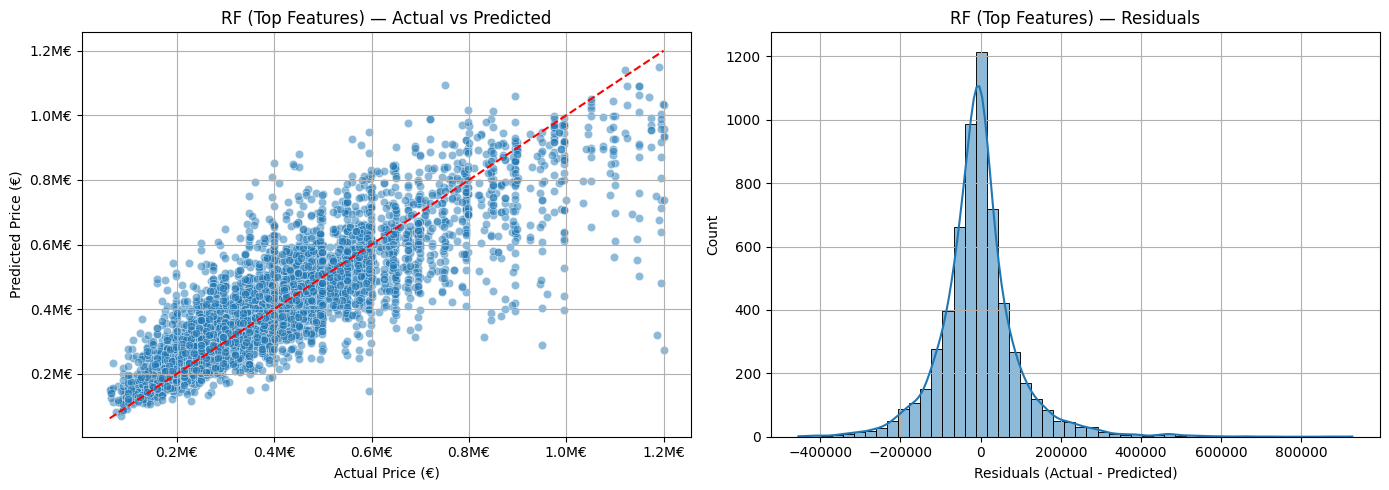

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Formatter pour les axes en millions d’euros
million_formatter = FuncFormatter(lambda x, _: f'{x / 1_000_000:.1f}M€')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot : prix réels vs prédits
sns.scatterplot(x=y_test_top, y=y_pred_rf_top, alpha=0.5, ax=axes[0])
axes[0].plot([y_test_top.min(), y_test_top.max()], [y_test_top.min(), y_test_top.max()], '--', color='red')
axes[0].set_title("RF (Top Features) — Actual vs Predicted")
axes[0].set_xlabel("Actual Price (€)")
axes[0].set_ylabel("Predicted Price (€)")
axes[0].xaxis.set_major_formatter(million_formatter)
axes[0].yaxis.set_major_formatter(million_formatter)
axes[0].grid(True)

# Histogramme des résidus
sns.histplot(residuals_rf_top, bins=50, kde=True, ax=axes[1])
axes[1].set_title("RF (Top Features) — Residuals")
axes[1].set_xlabel("Residuals (Actual - Predicted)")
axes[1].grid(True)

plt.tight_layout()
plt.show()



## Random Forest (Top Features) — Prediction vs Residual Analysis

### Interpretation

**Left Plot: Actual vs Predicted**
- The scatter plot shows the relationship between actual and predicted house prices using only the top features in the Random Forest model.
- Predictions remain fairly accurate for mid-range properties (up to ~&euro;700K), but show higher variance for more expensive properties.
- Some dispersion is observed above the red diagonal, indicating a tendency to underpredict high-value homes.

**Right Plot: Residuals Distribution**
- The residuals are tightly concentrated around zero, forming a nearly symmetric bell-shaped distribution.
- The peak is slightly higher than in the full-feature model, suggesting better performance on core features.
- The tails remain relatively light, which implies that the model maintains stability and avoids large prediction errors even with fewer inputs.

### Conclusion
The Random Forest model using only top features performs comparably to the full-feature model, maintaining strong predictive accuracy and well-behaved residuals. This indicates that a reduced feature set can capture most of the variance in the target variable, enabling efficient and interpretable modeling without significant loss of performance.


# Residual Distribution by Price Range — Random Forest (All Features)


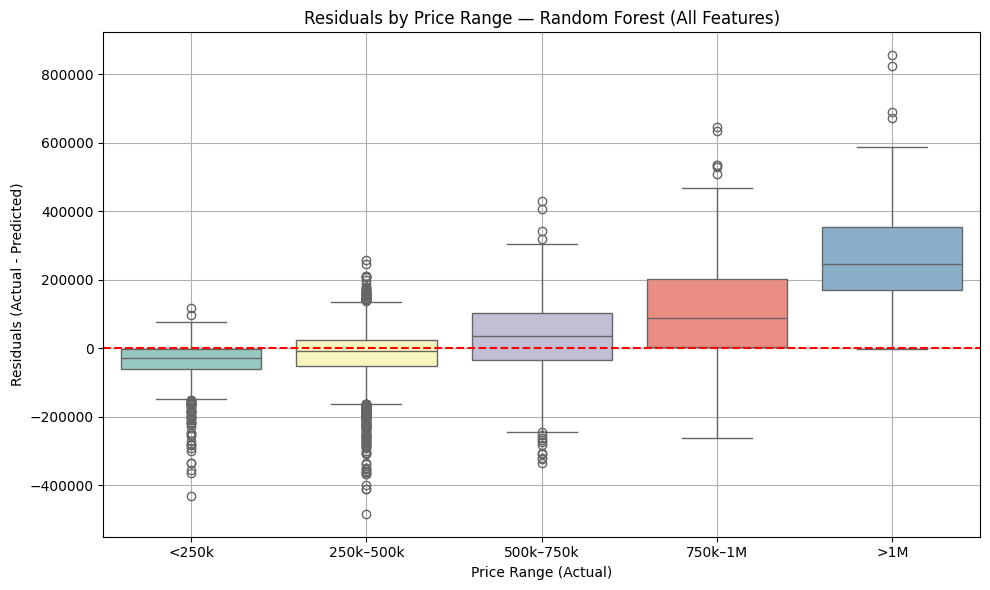

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load test predictions and true values (simulate for the purpose of plotting)
# These would be defined during model evaluation
# For demonstration, let's use dummy placeholders
# Replace y_test and y_pred_rf_all with real variables if running this in context

# Assuming y_test and y_pred_rf_all already exist from previous code
# Compute the residuals (errors between actual and predicted prices)
residuals_rf = y_test - y_pred_rf_all

# Création du DataFrame pour l’analyse des résidus
residuals_df = pd.DataFrame({
    "actual_price": y_test,
    "predicted_price": y_pred_rf_all,
    "residual": residuals_rf
})

# Define price ranges (bins) to group properties by actual price
bins = [0, 250000, 500000, 750000, 1000000, np.inf]
labels = ['<250k', '250k–500k', '500k–750k', '750k–1M', '>1M']
residuals_df["price_range"] = pd.cut(residuals_df["actual_price"], bins=bins, labels=labels)

# === Boxplot of residuals per price range ===
plt.figure(figsize=(10, 6))

# Create a boxplot to visualize residual distribution for each price range
sns.boxplot(x="price_range", y="residual", data=residuals_df, hue="price_range", palette="Set3", legend=False)


# Add a red dashed horizontal line at y=0 to indicate perfect prediction
plt.axhline(0, color="red", linestyle="--")

# Add titles and labels
plt.title("Residuals by Price Range — Random Forest (All Features)")
plt.xlabel("Price Range (Actual)")
plt.ylabel("Residuals (Actual - Predicted)")

# Add grid and layout formatting
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


# Residuals by Price Range — Random Forest (All Features)

This boxplot shows how prediction errors (residuals) vary across different price segments using the Random Forest model trained on all features.

## Interpretation

- **Low-priced properties (<&euro;500k)** have residuals mostly centered around 0, indicating balanced predictions with relatively low error dispersion.
- **Mid-range properties (&euro;500k–&euro;750k)** start to show a positive bias — predicted prices tend to be lower than actual prices, as shown by the median being above zero.
- **High-end properties (>&euro;750k)** exhibit a growing upward bias. The model increasingly underestimates actual prices, as the residuals shift further above zero.
- The spread of residuals becomes wider for expensive homes, reflecting greater variability and decreased prediction accuracy.
- **Outliers** (dots) are more common in high-price segments, suggesting that very expensive properties are more challenging for the model.

**Conclusion**:  
While the Random Forest model performs well for low to mid-priced properties, its ability to predict prices accurately decreases significantly as the price increases. This indicates the need for either additional high-value-specific features, stratified modeling, or price-segment-based models.


---
## Global Conclusion — Model Behavior Across All Visualizations

Across all model evaluations and visualizations, several key insights emerge regarding model performance and behavior:

### 1. **Random Forest Outperforms Linear Regression**

- In **every setup**, Random Forest shows superior predictive power compared to Linear Regression — both in terms of:
  - Lower errors (MAE, RMSE)
  - Higher explanatory power (R<sup>2</sup> score)
  - Tighter and more symmetric residual distributions
- Visuals confirm this: Random Forest predictions are more tightly clustered around the ideal prediction line (y = x), and residuals are more narrowly distributed.

### 2. **Using All Features Improves Accuracy**

- Models using **all available features** outperform those using only the top selected features.
- While reducing to top features slightly reduces computational complexity, it leads to:
  - Lower R<sup>2</sup> values
  - Higher residual variance
  - Less accurate predictions, especially for high-value properties

### 3. **Systematic Biases in Predictions**

- Both models **underestimate high-value properties** (above &euro;750k), especially visible in:
  - The scatter plots (predictions fall below the actual values)
  - The boxplot of residuals (positive bias in residuals as price increases)
- This suggests that the model lacks fine-tuned features or nonlinear interactions that can better capture the behavior of luxury property prices.

### 4. **Residuals Are Not Randomly Distributed**

- In well-performing models, residuals should follow a normal distribution centered on zero.
- Random Forest residuals approximate this shape well, while Linear Regression exhibits more spread and skewness.
- For both models, residuals tend to increase in magnitude with price, indicating **heteroscedasticity** (non-constant error variance), a challenge common in real-estate regression.

---

### Final Recommendation

- **Random Forest with all features** is the most robust baseline model.
- To go further:
  - Integrate **gradient boosting models** (e.g., XGBoost, LightGBM)
  - Explore **log-transforming price** to mitigate skewness and heteroscedasticity
  - Test **ensemble or segmented models** by price range
  - Use **feature engineering** to better capture high-end property characteristics

These visualizations and evaluations offer a strong diagnostic view of model performance and suggest where further refinement is most needed.

---



### 3.2 Try Advanced Models

To push performance beyond current results:

- **Train XGBoost** (Extreme Gradient Boosting):  
  A highly efficient and accurate model often outperforming Random Forest.

- **Try other alternatives**:
- **Train LightGBM** (Gradient Boosting with leaf-wise tree growth)
- **Train CatBoost** (handles categorical variables natively)

- **Optimize hyperparameters**:  
  Use **GridSearchCV**, **RandomizedSearchCV**, or **Optuna** to fine-tune model performance.


# Real Estate Price Prediction using XGBoost  
### Comparison Between Full Feature Model and Random Forest-Based Feature Selection

**XGBoost (Extreme Gradient Boosting)** is a powerful and scalable machine learning algorithm based on gradient boosting decision trees. It is widely used for structured/tabular data due to its performance, speed, and ability to handle non-linear relationships.

In this notebook, we use XGBoost to predict real estate prices using a fully preprocessed dataset. We compare two approaches:
- **XGBoost (All Features):** the model is trained on all preprocessed and encoded features (~3000+ one-hot encoded variables).
- **XGBoost (Top Features):** the model is trained only on the top 30 features ranked by feature importance from a Random Forest model.

Both models are evaluated using standard regression metrics (MAE, RMSE, R<sup>2</sup>) and analyzed through error distributions.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

def log_model_metrics(model_name, mae, rmse, r2, csv_path="../data/ML/model_metrics.csv"):
    new_entry = pd.DataFrame([{
        "model": model_name,
        "mae": round(mae, 2),
        "rmse": round(rmse, 2),
        "r2": round(r2, 4)
    }])
    new_entry.to_csv(csv_path, mode='a', index=False, header=False)
    print(f"Logged metrics for: {model_name}")

# 1. Load the preprocessed dataset
df = pd.read_csv("../data/ML/immoweb_real_estate_ml_ready.csv")

# 2. Drop rows with missing values
df = df.dropna()

# 3. Separate features and target
X = df.drop(columns=["price"])  # Use all columns except 'price'
y = df["price"]

# 4. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train XGBoost on all features using all CPU cores
xgb_all = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_all.fit(X_train, y_train)

# 6. Evaluate XGB (All Features)
y_pred_all = xgb_all.predict(X_test)
mae_all = mean_absolute_error(y_test, y_pred_all)
rmse_all = root_mean_squared_error(y_test, y_pred_all)
r2_all = r2_score(y_test, y_pred_all)

print("XGB (All Features) Evaluation:")
print(f"MAE  : {mae_all:.2f}")
print(f"RMSE : {rmse_all:.2f}")
print(f"R²   : {r2_all:.4f}")

log_model_metrics("XGBoost (All Features)", mae_all, rmse_all, r2_all)

# 7. Train Random Forest to extract top features
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# 8. Extract top N features from RF
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 30
top_features_rf = X.columns[indices[:top_n]]

# 9. Train XGBoost on top features
X_top_train = X_train[top_features_rf]
X_top_test = X_test[top_features_rf]

xgb_top = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_top.fit(X_top_train, y_train)

# 10. Evaluate XGB (Top RF Features)
y_pred_top = xgb_top.predict(X_top_test)
mae_top = mean_absolute_error(y_test, y_pred_top)
rmse_top = root_mean_squared_error(y_test, y_pred_top)  
r2_top = r2_score(y_test, y_pred_top)

print("\nXGB (Top RF Features) Evaluation:")
print(f"MAE  : {mae_top:.2f}")
print(f"RMSE : {rmse_top:.2f}")
print(f"R²   : {r2_top:.4f}")


# Log model metrics for XGBoost with top features
log_model_metrics("XGBoost (Top RF Features)", mae_top, rmse_top, r2_top)

# Display model evaluation summary
display_model_log_and_best_model()



XGB (All Features) Evaluation:
MAE  : 66302.09
RMSE : 97431.35
R²   : 0.7649
Logged metrics for: XGBoost (All Features)

XGB (Top RF Features) Evaluation:
MAE  : 65661.18
RMSE : 97742.14
R²   : 0.7634
Logged metrics for: XGBoost (Top RF Features)

>>> Model Evaluation Summary (sorted by R²):


,model,mae,rmse,r2,best
0,XGBoost (All Features),66302.09,97431.35,0.7649,✓
1,XGBoost (Top RF Features),65661.18,97742.14,0.7634,
2,Random Forest (All Features),65705.67,98940.13,0.7576,
3,Random Forest (Top Features),67309.43,101408.12,0.7454,
4,Linear Regression (All Features),85510.11,121149.58,0.6366,
5,Linear Regression (Top Features),96534.10,136104.16,0.5413,



👉 Best model based on R²: XGBoost (All Features)


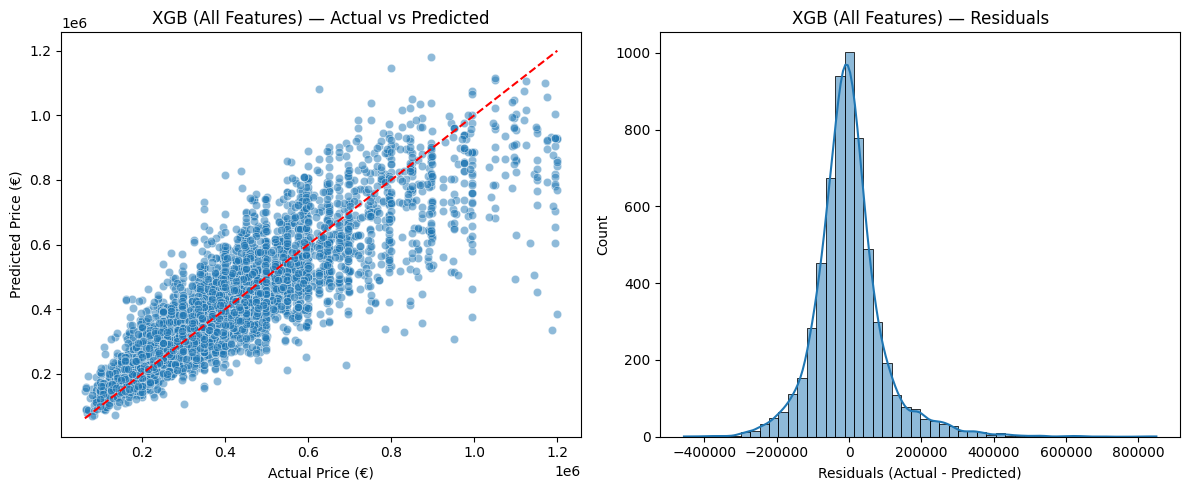

In [ ]:
# 6. Visualization — XGB (All Features)

# Calculate residuals if not already defined
residuals_all = y_test - y_pred_all

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_all, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price (€)")
plt.ylabel("Predicted Price (€)")
plt.title("XGB (All Features) — Actual vs Predicted")

plt.subplot(1, 2, 2)
sns.histplot(residuals_all, bins=50, kde=True)
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Count")
plt.title("XGB (All Features) — Residuals")
plt.tight_layout()
plt.show()

## Interpretation

### Left Plot: Actual vs Predicted

- The red diagonal represents perfect prediction (y = x).

- Most data points are well aligned along this diagonal, showing a strong correlation between actual and predicted prices.

- There is some visible dispersion at the extremes, meaning the model struggles slightly with very high or very low property prices.

- No major bias is detected — no consistent over- or under-estimation.

### Right Plot: Residuals Distribution

- The peak centered around 0 indicates that prediction errors are, on average, close to zero.

- The residual curve is roughly symmetric and well-shaped, which is a very positive sign.

- There is a slight right tail, suggesting some instances of significant underestimation (predicted prices lower than actual).

- No structural bias is apparent in the residuals.

### Conclusion

| Criterion            | Evaluation                        |
|---------------------|------------------------------------|
| Overall correlation | Excellent                          |
| Mean error          | Centered, no clear bias            |
| Extremes            | Minor deviation, no overfitting    |
| Distribution        | Stable, approximately Gaussian     |


## Residuals by Price Range (Boxplot)

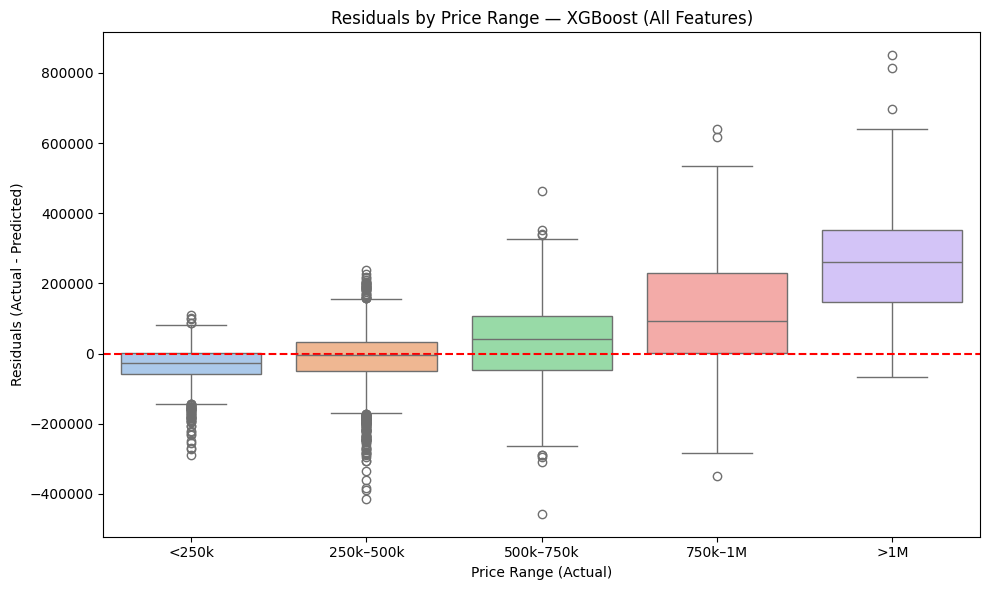

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Compute residuals and merge with actual prices
results_df = pd.DataFrame({
    "actual_price": y_test,
    "residuals": y_test - y_pred_all  # ou y_pred_top
})

# 2. Define price bins and labels
bins = [0, 250_000, 500_000, 750_000, 1_000_000, float('inf')]
labels = ['<250k', '250k–500k', '500k–750k', '750k–1M', '>1M']

# 3. Bin actual prices into ranges
results_df["price_range"] = pd.cut(results_df["actual_price"], bins=bins, labels=labels, include_lowest=True)

# 4. Plot boxplot of residuals by price range
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=results_df,
    x="price_range",
    y="residuals",
    hue="price_range",
    palette="pastel",
    legend=False
)
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel("Price Range (Actual)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals by Price Range — XGBoost (All Features)")
plt.tight_layout()
plt.show()


## Interpretation – Residuals by Price Range (XGBoost – All Features)

### Overview

Each boxplot shows residuals (actual - predicted) for a given price range.  
- Boxes above 0 → underestimation  
- Boxes below 0 → overestimation  
- The red dashed line at 0 marks perfect prediction

### Key Observations

| Price Range | Bias             | Comment                                               |
|-------------|------------------|--------------------------------------------------------|
| `<250k`     | Overestimation   | Model predicts too high for cheap properties          |
| `250k–750k` | Slight overestimation | Fairly balanced, best overall performance        |
| `750k–1M`   | Underestimation  | Model underpredicts higher-priced homes               |
| `>1M`       | Strong underestimation | Struggles to capture luxury market dynamics     |

### Conclusion

- Model is well-tuned for mid-range properties (250k–750k)  
- Overpredicts at the low end, underpredicts at the high end  
- Residuals widen with price → more uncertainty on expensive homes
---

# Real Estate Price Prediction using Gradient Boosting

## Comparison Between Full Feature Model and Reduced Feature Model

**Gradient Boosting Regressor** is a robust ensemble machine learning algorithm based on boosting weak learners (typically decision trees) to form a strong predictive model. It is well-suited for structured/tabular data and performs well even on moderately complex datasets. Unlike linear models, it captures non-linear patterns and interactions between features.

In this notebook, we apply Gradient Boosting to predict real estate prices on a cleaned and preprocessed dataset. We compare two model configurations:

- **GradientBoosting (All Features):** the model is trained on all available features after preprocessing and encoding.
- **GradientBoosting (Reduced Features):** the model is trained only on a selected subset of features identified through feature importance from a Random Forest.

Both versions are evaluated using common regression metrics (MAE, RMSE, R<sup>2</sup>) and compared through visual analysis of residuals and prediction error distributions.


Gradient Boosting Regressor – All Features
  MAE:  76,999.33 €
  RMSE: 110,878.68 €
  R²:   0.6956
----------------------------------------
Logged metrics for: GradientBoosting (All Features)


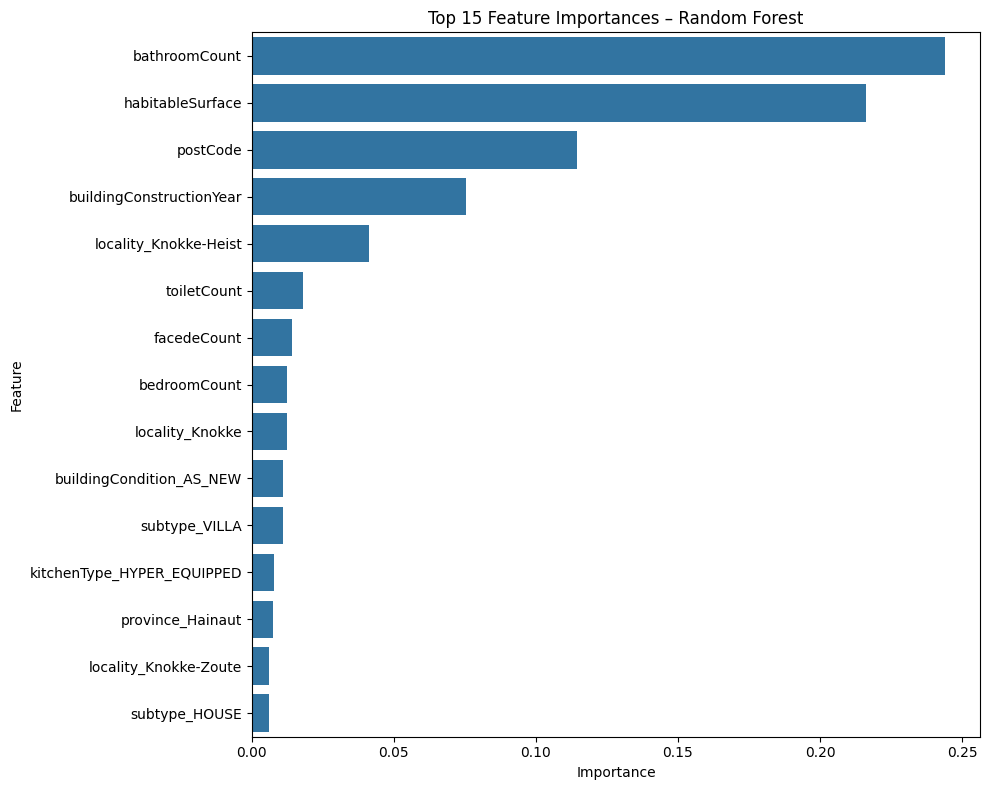

Gradient Boosting Regressor – Top 30 Features (from RF)
  MAE:  76,517.08 €
  RMSE: 110,878.68 €
  R²:   0.6963
----------------------------------------
Logged metrics for: GradientBoosting (Top RF Features)

>>> Model Evaluation Summary (sorted by R²):


,model,mae,rmse,r2,best
0,XGBoost (All Features),66302.09,97431.35,0.7649,✓
1,XGBoost (Top RF Features),65661.18,97742.14,0.7634,
2,Random Forest (All Features),65705.67,98940.13,0.7576,
3,Random Forest (Top Features),67309.43,101408.12,0.7454,
4,GradientBoosting (Top RF Features),76517.08,110878.68,0.6963,
5,GradientBoosting (All Features),76999.33,110878.68,0.6956,
6,Linear Regression (All Features),85510.11,121149.58,0.6366,
7,Linear Regression (Top Features),96534.10,136104.16,0.5413,



👉 Best model based on R²: XGBoost (All Features)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from IPython.display import display
from sklearn.metrics import root_mean_squared_error


# === 1. Load dataset ===
df = pd.read_csv("../data/ML/immoweb_real_estate_ml_ready.csv")
X = df.drop(columns=["price"])
y = df["price"]

# === 2. Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === 3. Train GBR on all features ===
gbr_full = GradientBoostingRegressor(random_state=42)
gbr_full.fit(X_train, y_train)
y_pred_full = gbr_full.predict(X_test)

mae_full = mean_absolute_error(y_test, y_pred_full)
rmse_full = root_mean_squared_error(y_test, y_pred_full)
r2_full = r2_score(y_test, y_pred_full)

print("Gradient Boosting Regressor – All Features")
print(f"  MAE:  {mae_full:,.2f} €")
print(f"  RMSE: {rmse_full:,.2f} €")
print(f"  R²:   {r2_full:.4f}")
print("-" * 40)

log_model_metrics("GradientBoosting (All Features)", mae_full, rmse_full, r2_full)

# === 4. Feature selection using Random Forest ===
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
top_features_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plot top 15 features (optional)
plt.figure(figsize=(10, 8))
sns.barplot(data=top_features_df.head(15), x="importance", y="feature")
plt.title("Top 15 Feature Importances – Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# === 5. Train GBR on top 30 features ===
top_n = 30
top_n_features = top_features_df["feature"].head(top_n).tolist()
X_train_reduced = X_train[top_n_features]
X_test_reduced = X_test[top_n_features]

gbr_reduced = GradientBoostingRegressor(random_state=42)
gbr_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = gbr_reduced.predict(X_test_reduced)

mae_reduced = mean_absolute_error(y_test, y_pred_reduced)
rmse_reduced = root_mean_squared_error(y_test, y_pred_full)
r2_reduced = r2_score(y_test, y_pred_reduced)

print("Gradient Boosting Regressor – Top 30 Features (from RF)")
print(f"  MAE:  {mae_reduced:,.2f} €")
print(f"  RMSE: {rmse_reduced:,.2f} €")
print(f"  R²:   {r2_reduced:.4f}")
print("-" * 40)

log_model_metrics("GradientBoosting (Top RF Features)", mae_reduced, rmse_reduced, r2_reduced)

# === Final summary ===
display_model_log_and_best_model()


C:\Users\Neo\AppData\Local\Temp\ipykernel_25764\3313174177.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


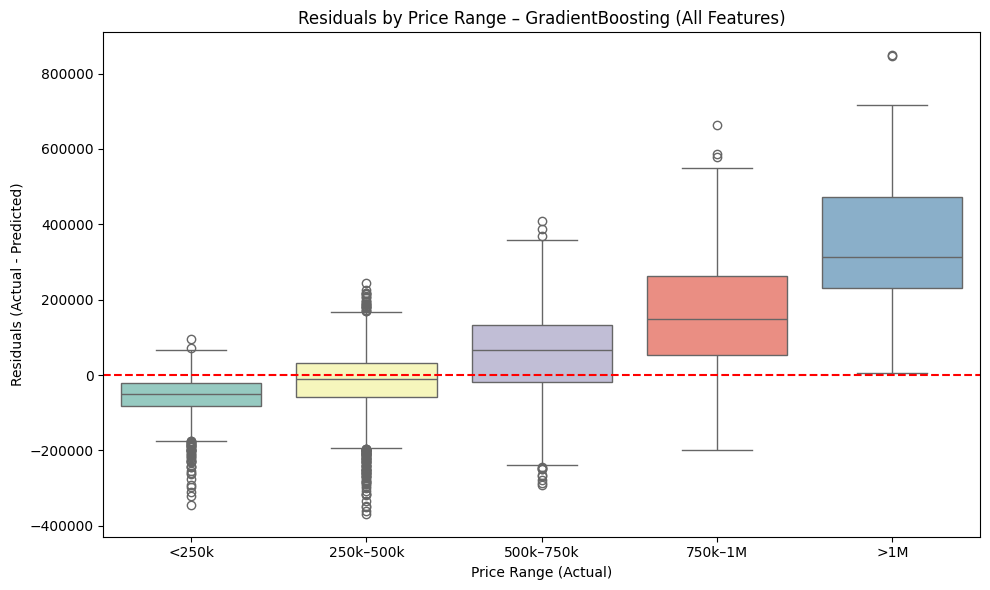

In [ ]:
# === Residuals by Price Range (for GradientBoosting – All Features) ===

# 1. Create residuals DataFrame
results_df = pd.DataFrame({
    "actual_price": y_test,
    "residuals": y_test - y_pred_full  # attention : y_pred_full déjà défini plus haut
})

# 2. Define bins and labels
bins = [0, 250_000, 500_000, 750_000, 1_000_000, float("inf")]
labels = ['<250k', '250k–500k', '500k–750k', '750k–1M', '>1M']

# 3. Cut prices into bins
results_df["price_range"] = pd.cut(results_df["actual_price"], bins=bins, labels=labels, include_lowest=True)

# 4. Boxplot of residuals by price range
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=results_df,
    x="price_range",
    y="residuals",
    palette="Set3"
)
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel("Price Range (Actual)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals by Price Range – GradientBoosting (All Features)")
plt.tight_layout()
plt.show()


# Real Estate Price Prediction using LightGBM

## Comparison Between Full Feature Model and Reduced Feature Model

**LightGBM (Light Gradient Boosting Machine)** is an efficient and scalable gradient boosting framework that uses histogram-based learning to speed up training and reduce memory usage. It is highly optimized for performance and is especially effective on large, structured/tabular datasets with many categorical or sparse features.

In this notebook, we apply LightGBM to predict real estate prices on a cleaned and preprocessed dataset. We compare two model configurations:

- **LightGBM (All Features):** the model is trained on all available features after preprocessing and encoding.
- **LightGBM (Top RF Features):** the model is trained only on a selected subset of features ranked by feature importance from a Random Forest.

Both versions are evaluated using standard regression metrics (MAE, RMSE, R<sup>2</sup>) and are compared through visual inspection of residuals and error distributions.


In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split

# === Load dataset ===
df = pd.read_csv("../data/ML/immoweb_real_estate_ml_ready.csv").dropna()
X = df.drop(columns=["price"])
y = df["price"]

# Clean feature names BEFORE split
X.columns = X.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)
X = X.loc[:, ~X.columns.duplicated()]  # remove duplicate columns

# === Train-test split (after cleaning) ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === LightGBM on all features ===
lgbm_all = LGBMRegressor(random_state=42)
lgbm_all.fit(X_train, y_train)
y_pred_lgbm_all = lgbm_all.predict(X_test)

mae_lgbm_all = mean_absolute_error(y_test, y_pred_lgbm_all)
rmse_lgbm_all = root_mean_squared_error(y_test, y_pred_lgbm_all)
r2_lgbm_all = r2_score(y_test, y_pred_lgbm_all)

print("LightGBM (All Features) Evaluation:")
print(f"  MAE:  {mae_lgbm_all:,.2f} €")
print(f"  RMSE: {rmse_lgbm_all:,.2f} €")
print(f"  R²:   {r2_lgbm_all:.4f}")
print("-" * 40)

log_model_metrics("LightGBM (All Features)", mae_lgbm_all, rmse_lgbm_all, r2_lgbm_all)

# === Select top 30 features via Random Forest ===
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
feature_names = X_train.columns
top_n_features = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30).index.tolist()

# === LightGBM on top 30 features ===
X_train_top = X_train[top_n_features]
X_test_top = X_test[top_n_features]

lgbm_top = LGBMRegressor(random_state=42)
lgbm_top.fit(X_train_top, y_train)
y_pred_lgbm_top = lgbm_top.predict(X_test_top)

mae_lgbm_top = mean_absolute_error(y_test, y_pred_lgbm_top)
rmse_lgbm_top = root_mean_squared_error(y_test, y_pred_lgbm_top)
r2_lgbm_top = r2_score(y_test, y_pred_lgbm_top)

print("LightGBM (Top 30 Features from RF) Evaluation:")
print(f"  MAE:  {mae_lgbm_top:,.2f} €")
print(f"  RMSE: {rmse_lgbm_top:,.2f} €")
print(f"  R²:   {r2_lgbm_top:.4f}")
print("-" * 40)

log_model_metrics("LightGBM (Top RF Features)", mae_lgbm_top, rmse_lgbm_top, r2_lgbm_top)

# === Summary display ===
display_model_log_and_best_model()






[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1388
[LightGBM] [Info] Number of data points in the train set: 24151, number of used features: 353
[LightGBM] [Info] Start training from score 394984.220819
LightGBM (All Features) Evaluation:
  MAE:  65,548.48 €
  RMSE: 97,417.23 €
  R²:   0.7650
----------------------------------------
Logged metrics for: LightGBM (All Features)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 742
[LightGBM] [Info] Number of data points in the train set: 24151, number of used features: 30
[LightGBM] [Info] Start training from score 394984.220819
Li

,model,mae,rmse,r2,best
0,LightGBM (All Features),65548.48,97417.23,0.7650,✓
1,XGBoost (All Features),66302.09,97431.35,0.7649,
2,XGBoost (Top RF Features),65661.18,97742.14,0.7634,
3,Random Forest (All Features),65705.67,98940.13,0.7576,
4,LightGBM (Top RF Features),67205.03,99709.18,0.7538,
5,Random Forest (Top Features),67309.43,101408.12,0.7454,
6,GradientBoosting (Top RF Features),76517.08,110878.68,0.6963,
7,GradientBoosting (All Features),76999.33,110878.68,0.6956,
8,Linear Regression (All Features),85510.11,121149.58,0.6366,
9,Linear Regression (Top Features),96534.10,136104.16,0.5413,



👉 Best model based on R²: LightGBM (All Features)


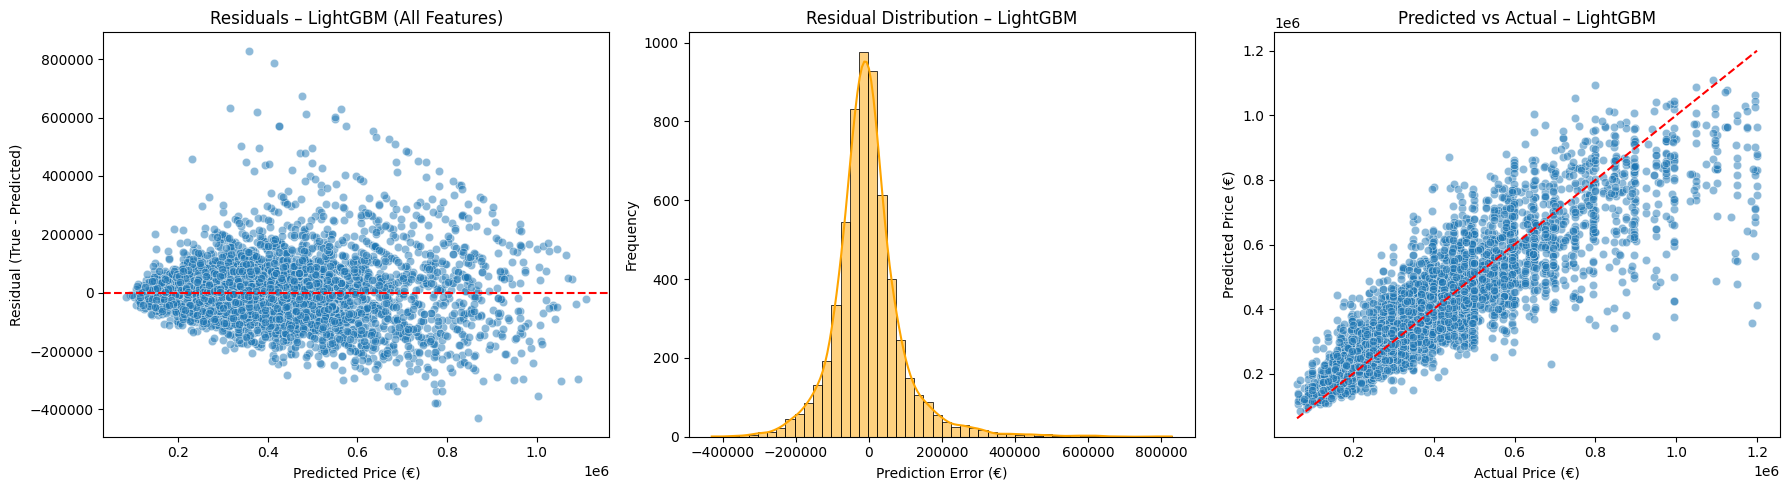

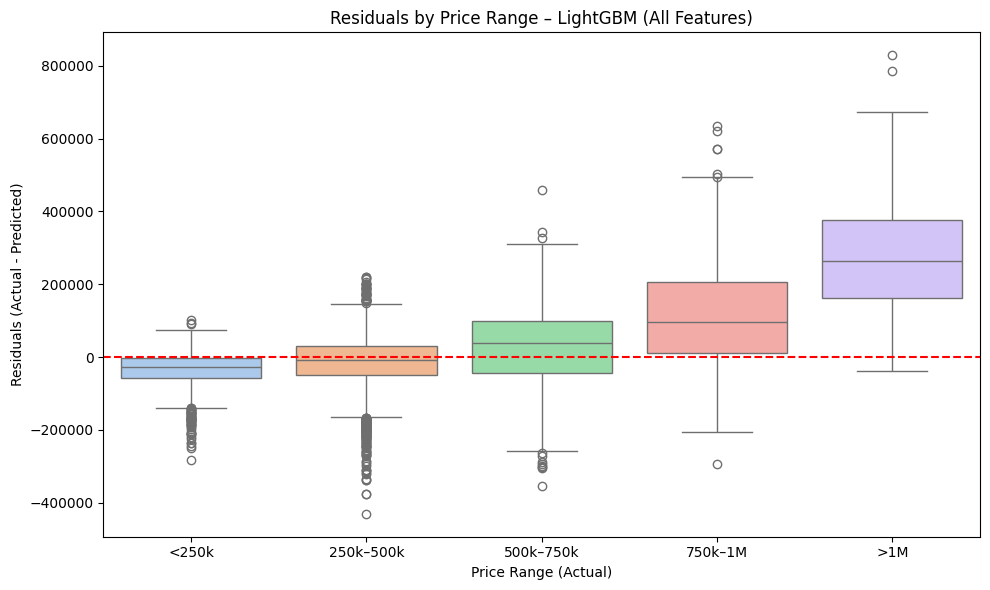

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute residuals
residuals = y_test - y_pred_lgbm_all

# Create 3 plots on one line
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1 – Residuals vs Predicted
sns.scatterplot(ax=axes[0], x=y_pred_lgbm_all, y=residuals, alpha=0.5)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title("Residuals – LightGBM (All Features)")
axes[0].set_xlabel("Predicted Price (€)")
axes[0].set_ylabel("Residual (True - Predicted)")

# Plot 2 – Residual distribution
sns.histplot(residuals, bins=50, kde=True, color="orange", ax=axes[1])
axes[1].set_title("Residual Distribution – LightGBM")
axes[1].set_xlabel("Prediction Error (€)")
axes[1].set_ylabel("Frequency")

# Plot 3 – Predicted vs Actual
sns.scatterplot(ax=axes[2], x=y_test, y=y_pred_lgbm_all, alpha=0.5)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[2].set_title("Predicted vs Actual – LightGBM")
axes[2].set_xlabel("Actual Price (€)")
axes[2].set_ylabel("Predicted Price (€)")

# Final layout
plt.tight_layout()
plt.show()


# Compute residuals
results_df = pd.DataFrame({
    "actual_price": y_test,
    "residuals": y_test - y_pred_lgbm_all
})

# Define price bins and labels
bins = [0, 250_000, 500_000, 750_000, 1_000_000, float('inf')]
labels = ['<250k', '250k–500k', '500k–750k', '750k–1M', '>1M']
results_df["price_range"] = pd.cut(results_df["actual_price"], bins=bins, labels=labels, include_lowest=True)

# Plot residuals
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=results_df,
    x="price_range",
    y="residuals",
    hue="price_range",
    palette="pastel",
    legend=False
)
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel("Price Range (Actual)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals by Price Range – LightGBM (All Features)")
plt.tight_layout()
plt.show()



# Real Estate Price Prediction using CatBoost

## Comparison Between Full Feature Model and Reduced Feature Model

**CatBoost (Categorical Boosting)** is a state-of-the-art gradient boosting algorithm developed by Yandex. It is specifically designed to handle categorical variables natively without requiring extensive preprocessing or one-hot encoding. CatBoost delivers strong predictive performance, avoids overfitting through sophisticated regularization techniques, and is well-suited for both small and large tabular datasets.

In this notebook, we use CatBoost to predict real estate prices based on a structured and preprocessed dataset. We compare two model configurations:

- **CatBoost (All Features):** the model is trained on the full set of features after preprocessing.
- **CatBoost (Top RF Features):** the model is trained only on the top 30 features selected using feature importance from a Random Forest.

Both versions are evaluated using standard regression metrics (MAE, RMSE, R<sup>2</sup>) and compared through residual plots and prediction error analysis.


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
import os

# === Load dataset ===
df = pd.read_csv("../data/ML/immoweb_real_estate_ml_ready.csv").dropna()
X = df.drop(columns=["price"])
y = df["price"]

# Clean column names
X.columns = X.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)
X = X.loc[:, ~X.columns.duplicated()]  # Remove duplicates

# === Split train/test ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Train CatBoost on all features ===
cat_all = CatBoostRegressor(verbose=0, random_state=42)
cat_all.fit(X_train, y_train)
y_pred_cat_all = cat_all.predict(X_test)

mae_all = mean_absolute_error(y_test, y_pred_cat_all)
rmse_all = root_mean_squared_error(y_test, y_pred_cat_all)
r2_all = r2_score(y_test, y_pred_cat_all)

print("CatBoost (All Features) Evaluation:")
print(f"  MAE:  {mae_all:,.2f} €")
print(f"  RMSE: {rmse_all:,.2f} €")
print(f"  R²:   {r2_all:.4f}")
print("-" * 40)

# === Feature importance with Random Forest ===
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(30).index.tolist()

# === Train CatBoost on top 30 features ===
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

cat_top = CatBoostRegressor(verbose=0, random_state=42)
cat_top.fit(X_train_top, y_train)
y_pred_cat_top = cat_top.predict(X_test_top)

mae_top = mean_absolute_error(y_test, y_pred_cat_top)
rmse_top = root_mean_squared_error(y_test, y_pred_cat_top)
r2_top = r2_score(y_test, y_pred_cat_top)

print("CatBoost (Top RF Features) Evaluation:")
print(f"  MAE:  {mae_top:,.2f} €")
print(f"  RMSE: {rmse_top:,.2f} €")
print(f"  R²:   {r2_top:.4f}")
print("-" * 40)

# === Log to CSV using existing function ===
log_model_metrics("CatBoost (All Features)", mae_all, rmse_all, r2_all)
log_model_metrics("CatBoost (Top RF Features)", mae_top, rmse_top, r2_top)

# === Display summary using existing function ===
display_model_log_and_best_model()


CatBoost (All Features) Evaluation:
  MAE:  65,032.25 €
  RMSE: 95,451.36 €
  R²:   0.7744
----------------------------------------
CatBoost (Top RF Features) Evaluation:
  MAE:  64,368.78 €
  RMSE: 95,924.36 €
  R²:   0.7722
----------------------------------------
Logged metrics for: CatBoost (All Features)
Logged metrics for: CatBoost (Top RF Features)

>>> Model Evaluation Summary (sorted by R²):


,model,mae,rmse,r2,best
0,CatBoost (All Features),65032.25,95451.36,0.7744,✓
1,CatBoost (Top RF Features),64368.78,95924.36,0.7722,
2,LightGBM (All Features),65548.48,97417.23,0.7650,
3,XGBoost (All Features),66302.09,97431.35,0.7649,
4,XGBoost (Top RF Features),65661.18,97742.14,0.7634,
5,Random Forest (All Features),65705.67,98940.13,0.7576,
6,LightGBM (Top RF Features),67205.03,99709.18,0.7538,
7,Random Forest (Top Features),67309.43,101408.12,0.7454,
8,GradientBoosting (Top RF Features),76517.08,110878.68,0.6963,
9,GradientBoosting (All Features),76999.33,110878.68,0.6956,



👉 Best model based on R²: CatBoost (All Features)


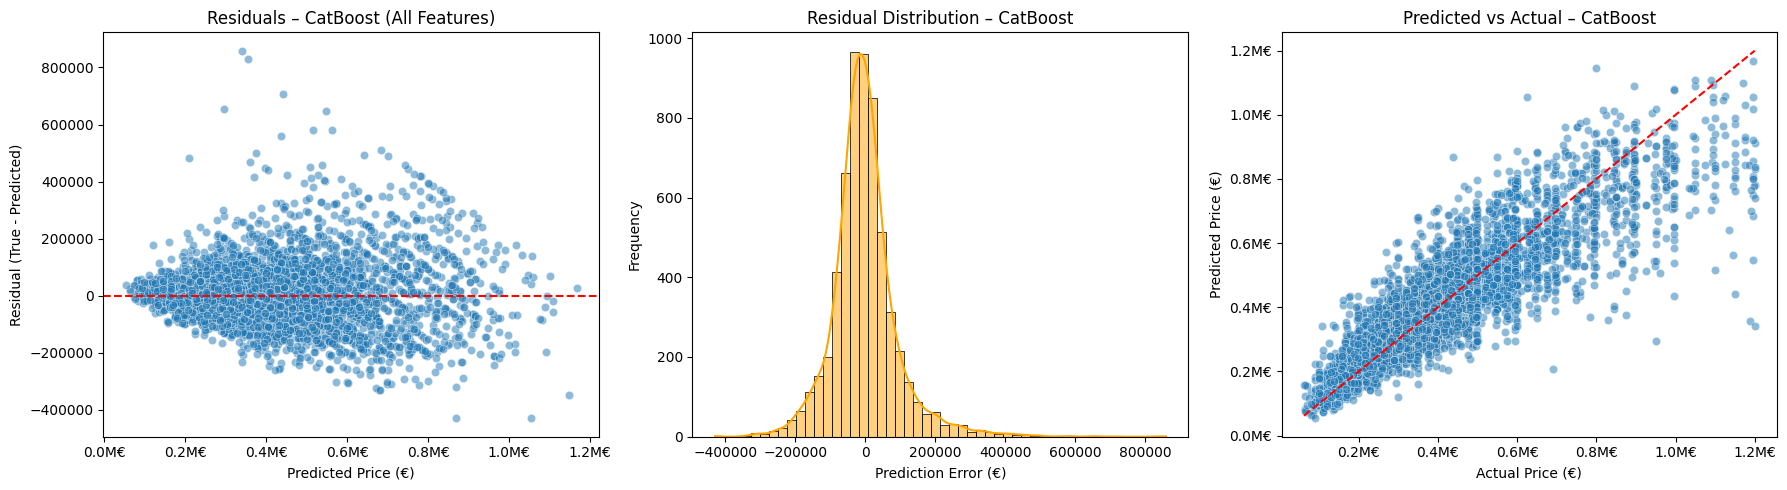

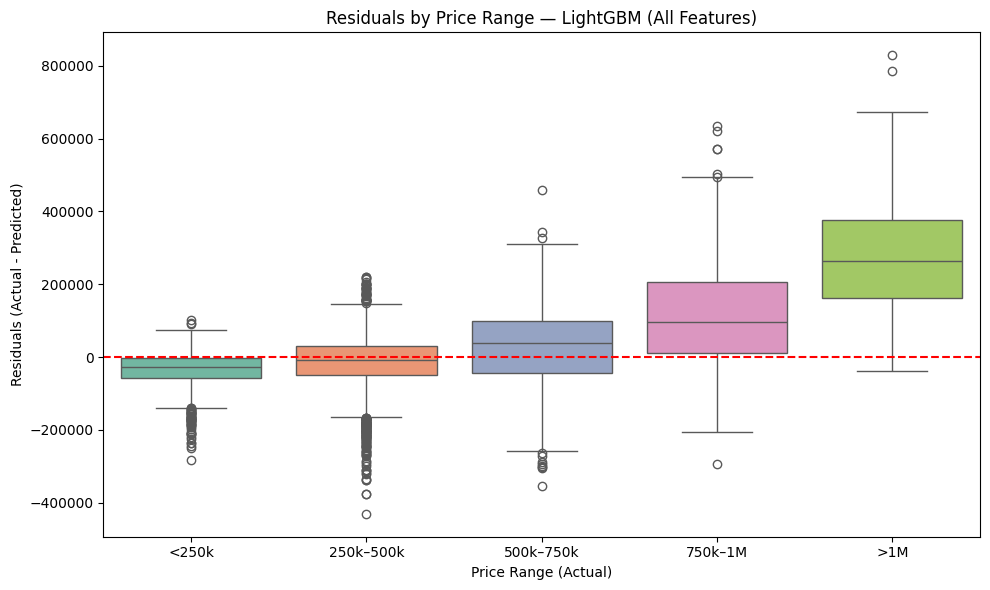

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np

# Prepare residuals
residuals = y_test - y_pred_cat_all
results_df = pd.DataFrame({
    "actual_price": y_test,
    "predicted_price": y_pred_cat_all,
    "residual": residuals
})

# === Function to convert axis to millions ===
def millions(x, pos):
    return f"{x * 1e-6:.1f}M€"

formatter = FuncFormatter(millions)

# === Plot all three side-by-side ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Residuals vs Predicted
sns.scatterplot(ax=axes[0], x=results_df["predicted_price"], y=results_df["residual"], alpha=0.5)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title("Residuals – CatBoost (All Features)")
axes[0].set_xlabel("Predicted Price (€)")
axes[0].set_ylabel("Residual (True - Predicted)")
axes[0].xaxis.set_major_formatter(formatter)

# 2. Residual distribution
sns.histplot(ax=axes[1], data=results_df, x="residual", bins=50, kde=True, color="orange")
axes[1].set_title("Residual Distribution – CatBoost")
axes[1].set_xlabel("Prediction Error (€)")
axes[1].set_ylabel("Frequency")

# 3. Predicted vs Actual
sns.scatterplot(ax=axes[2], x=results_df["actual_price"], y=results_df["predicted_price"], alpha=0.5)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[2].set_title("Predicted vs Actual – CatBoost")
axes[2].set_xlabel("Actual Price (€)")
axes[2].set_ylabel("Predicted Price (€)")
axes[2].xaxis.set_major_formatter(formatter)
axes[2].yaxis.set_major_formatter(formatter)

# === Final layout ===
plt.tight_layout()
plt.show()


# === Residuals by Price Range – LightGBM (All Features) ===
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create residuals DataFrame
results_lgbm = pd.DataFrame({
    "actual_price": y_test,
    "residuals": y_test - y_pred_lgbm_all
})

# 2. Define price bins and labels
bins = [0, 250_000, 500_000, 750_000, 1_000_000, float("inf")]
labels = ['<250k', '250k–500k', '500k–750k', '750k–1M', '>1M']

# 3. Categorize prices into ranges
results_lgbm["price_range"] = pd.cut(results_lgbm["actual_price"], bins=bins, labels=labels, include_lowest=True)

# 4. Create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=results_lgbm,
    x="price_range",
    y="residuals",
    hue="price_range",
    palette="Set2",
    legend=False
)

plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel("Price Range (Actual)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals by Price Range — LightGBM (All Features)")
plt.tight_layout()
plt.show()


# Hyperparameter Tuning with Optuna for XGBoost

## Improving Performance through Automated Optimization

**Optuna** is an automatic hyperparameter optimization framework that uses a smart sampling strategy (Tree-structured Parzen Estimator - TPE) to efficiently explore the search space. When combined with **XGBoost**, Optuna helps fine-tune key model parameters such as `max_depth`, `learning_rate`, `n_estimators`, and `subsample` to achieve better predictive accuracy.

In this notebook section, we use Optuna to optimize the performance of an XGBoost model trained on real estate data. The objective is to minimize the Root Mean Squared Error (RMSE) on the validation set.

Key steps include:

- Defining the objective function and search space for XGBoost hyperparameters.
- Running a study with multiple trials to explore optimal combinations.
- Evaluating the best model configuration found by Optuna using standard metrics (MAE, RMSE, R<sup>2</sup>).
- Comparing results with the baseline (non-tuned) XGBoost model.

This approach provides a systematic way to improve model performance beyond default settings.


In [ ]:
import optuna
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import os


# === Load dataset ===
df = pd.read_csv("../data/ML/immoweb_real_estate_ml_ready.csv").dropna()
X = df.drop(columns=["price"])
y = df["price"]

# Clean feature names
X.columns = X.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)
X = X.loc[:, ~X.columns.duplicated()]

# === Train-test split ===
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# === Select top 30 features via Random Forest ===
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
top_features = pd.Series(importances, index=X_train.columns).sort_values(ascending=False).head(30).index.tolist()
X_train_top = X_train[top_features]
X_valid_top = X_valid[top_features]

# === Init log file ===
csv_path = "../data/ML/model_metrics.csv"
os.makedirs(os.path.dirname(csv_path), exist_ok=True)
if not os.path.exists(csv_path):
    pd.DataFrame(columns=["model", "mae", "rmse", "r2"]).to_csv(csv_path, index=False)

# === Define Optuna tuning function ===
def tune_xgb(X_train, X_valid, y_train, y_valid, n_trials=50):
    def objective(trial):
        params = {
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "n_estimators": trial.suggest_int("n_estimators", 100, 800),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),

            # Optimization parameters
            "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
        }
        # Use CPU cores for training
        #model = xgb.XGBRegressor(**params, random_state=42, n_jobs=-1)

        # Use GPU cores for training
        model = xgb.XGBRegressor(**params, tree_method="gpu_hist", random_state=42, n_jobs=-1)


        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        return root_mean_squared_error(y_valid, preds)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    return study

# === Tune both models ===
study_all = tune_xgb(X_train, X_valid, y_train, y_valid, n_trials=30)
study_top = tune_xgb(X_train_top, X_valid_top, y_train, y_valid, n_trials=30)

# === Train final models using best params ===

# Use CPU cores for training
#best_model_all = xgb.XGBRegressor(**study_all.best_params, random_state=42, n_jobs=-1)

# Use GPU cores for training
best_model_all = xgb.XGBRegressor(**study_all.best_params, tree_method="gpu_hist", random_state=42, n_jobs=-1)

best_model_all.fit(X_train, y_train)
y_pred_all = best_model_all.predict(X_valid)

best_model_top = xgb.XGBRegressor(**study_top.best_params, random_state=42, n_jobs=-1)
best_model_top.fit(X_train_top, y_train)
y_pred_top = best_model_top.predict(X_valid_top)

# === Evaluate and log ===
def log_model_metrics(model_name, mae, rmse, r2):
    if os.path.exists(csv_path):
        df_log = pd.read_csv(csv_path)
    else:
        df_log = pd.DataFrame(columns=["model", "mae", "rmse", "r2"])
    df_log = pd.concat([df_log, pd.DataFrame([{
        "model": model_name,
        "mae": mae,
        "rmse": rmse,
        "r2": r2
    }])], ignore_index=True)
    df_log.to_csv(csv_path, index=False)

mae_all = mean_absolute_error(y_valid, y_pred_all)
rmse_all = root_mean_squared_error(y_valid, y_pred_all)
r2_all = r2_score(y_valid, y_pred_all)

mae_top = mean_absolute_error(y_valid, y_pred_top)
rmse_top = root_mean_squared_error(y_valid, y_pred_top)
r2_top = r2_score(y_valid, y_pred_top)

print("XGBoost + Optuna (All Features) Evaluation:")
print(f"  MAE:  {mae_all:,.2f} €")
print(f"  RMSE: {rmse_all:,.2f} €")
print(f"  R²:   {r2_all:.4f}")
print("-" * 40)

print("XGBoost + Optuna (Top RF Features) Evaluation:")
print(f"  MAE:  {mae_top:,.2f} €")
print(f"  RMSE: {rmse_top:,.2f} €")
print(f"  R²:   {r2_top:.4f}")
print("-" * 40)

log_model_metrics("XGBoost + Optuna (All Features)", mae_all, rmse_all, r2_all)
log_model_metrics("XGBoost + Optuna (Top RF Features)", mae_top, rmse_top, r2_top)

# === Display summary ===
from IPython.display import display
summary_df = pd.read_csv(csv_path).drop_duplicates()
best_idx = summary_df["r2"].idxmax()
summary_df["best"] = ""
summary_df.loc[best_idx, "best"] = "✓"

print("Model Evaluation Summary:")
display(summary_df)
print(f"\n👉 Best model based on 'r2': {summary_df.loc[best_idx, 'model']} ✓")



e:\_SoftEng\_BeCode\real-estate-price-predictor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-26 21:31:04,684] A new study created in memory with name: no-name-b76b77cc-a02d-4762-a748-62c9a5030491
[I 2025-06-26 21:31:15,181] Trial 0 finished with value: 94264.33917505569 and parameters: {'max_depth': 8, 'learning_rate': 0.27647951176103247, 'n_estimators': 426, 'subsample': 0.6920828773314307, 'colsample_bytree': 0.753190240709002, 'reg_alpha': 0.7456446585369108, 'reg_lambda': 0.204224933635749}. Best is trial 0 with value: 94264.33917505569.
[I 2025-06-26 21:31:23,325] Trial 1 finished with value: 93435.75077463592 and parameters: {'max_depth': 9, 'learning_rate': 0.17253860442489782, 'n_estimators': 242, 'subsample': 0.7919397008684104, 'colsample_bytree': 0.5817920818409186, 'reg_alpha': 0.5

XGBoost + Optuna (All Features) Evaluation:
  MAE:  60,145.46 €
  RMSE: 90,036.50 €
  R²:   0.7993
----------------------------------------
XGBoost + Optuna (Top RF Features) Evaluation:
  MAE:  61,074.47 €
  RMSE: 91,959.10 €
  R²:   0.7906
----------------------------------------
Model Evaluation Summary:


,model,mae,rmse,r2,best
0,Linear Regression (All Features),85510.110000,121149.580000,0.636600,
1,Random Forest (All Features),65705.670000,98940.130000,0.757600,
2,Linear Regression (Top Features),96534.100000,136104.160000,0.541300,
3,Random Forest (Top Features),67309.430000,101408.120000,0.745400,
4,XGBoost (All Features),66302.090000,97431.350000,0.764900,
5,XGBoost (Top RF Features),65661.180000,97742.140000,0.763400,
6,GradientBoosting (All Features),76999.330000,110878.680000,0.695600,
7,GradientBoosting (Top RF Features),76517.080000,110878.680000,0.696300,
8,LightGBM (All Features),65548.480000,97417.230000,0.765000,
9,LightGBM (Top RF Features),67205.030000,99709.180000,0.753800,



👉 Best model based on 'r2': XGBoost + Optuna (All Features) ✓


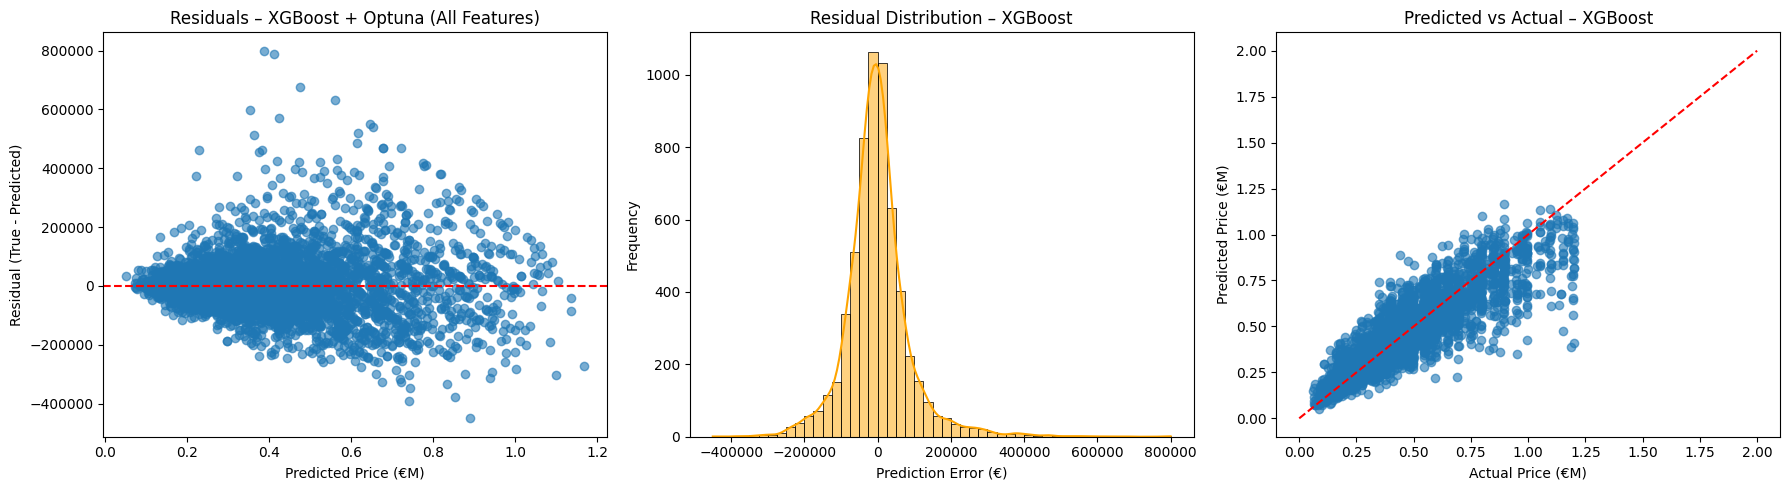

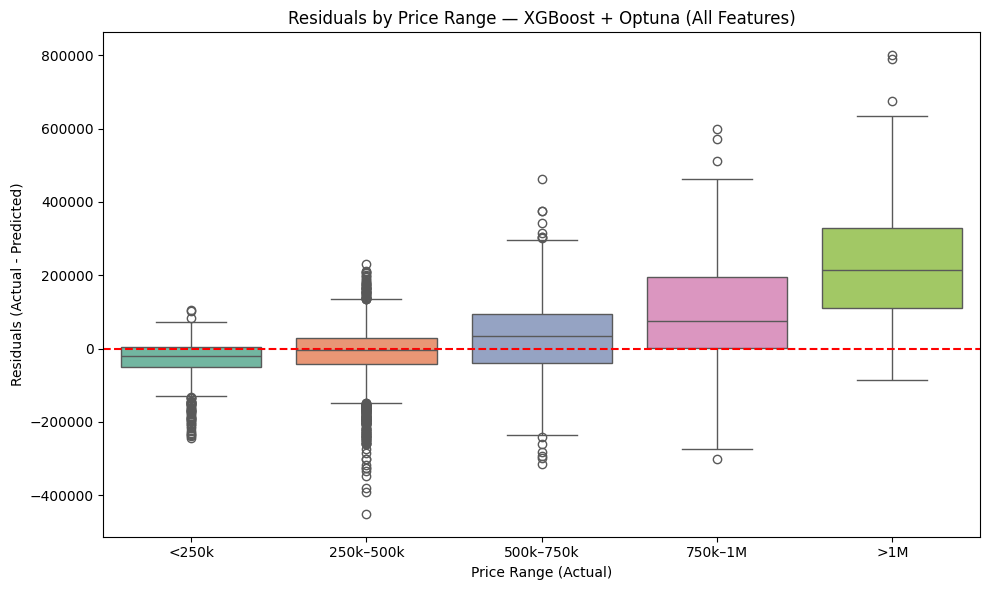

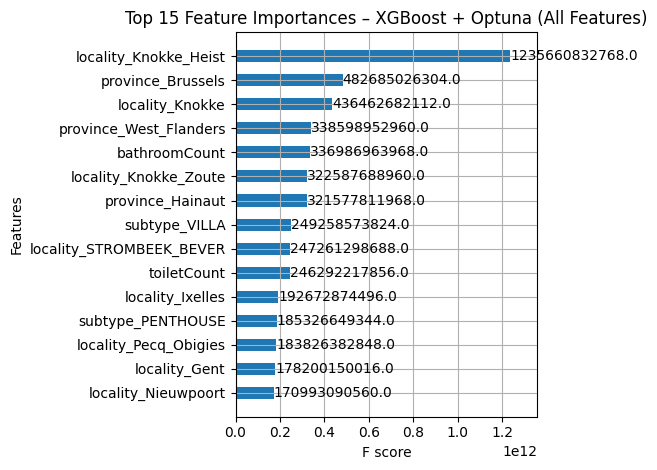

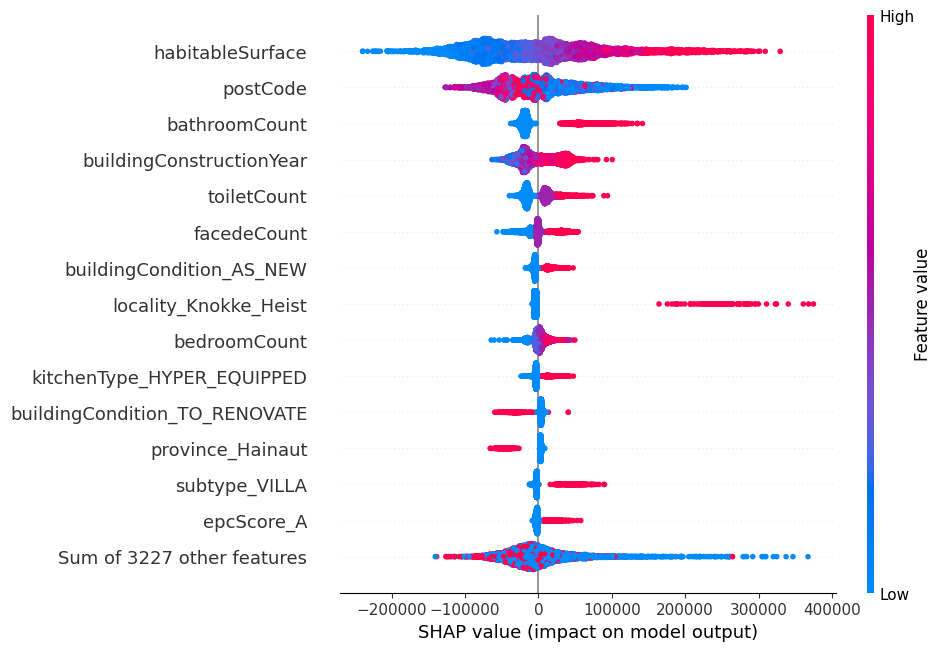

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# === Compute residuals ===
residuals = y_valid - y_pred_all
results_df = pd.DataFrame({
    "actual_price": y_valid,
    "predicted_price": y_pred_all,
    "residual": residuals
})

# === Price range bins and labels ===
bins = [0, 250000, 500000, 750000, 1000000, float('inf')]
labels = ['<250k', '250k–500k', '500k–750k', '750k–1M', '>1M']
results_df["price_range"] = pd.cut(results_df["actual_price"], bins=bins, labels=labels)

# === Plotting ===
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Residuals vs Predicted
axs[0].scatter(results_df["predicted_price"] / 1e6, results_df["residual"], alpha=0.6)
axs[0].axhline(0, color='red', linestyle='--')
axs[0].set_title("Residuals – XGBoost + Optuna (All Features)")
axs[0].set_xlabel("Predicted Price (€M)")
axs[0].set_ylabel("Residual (True - Predicted)")

# Plot 2: Residual Distribution
sns.histplot(results_df["residual"], bins=50, kde=True, color="orange", ax=axs[1])
axs[1].set_title("Residual Distribution – XGBoost")
axs[1].set_xlabel("Prediction Error (€)")
axs[1].set_ylabel("Frequency")

# Plot 3: Predicted vs Actual
axs[2].scatter(results_df["actual_price"] / 1e6, results_df["predicted_price"] / 1e6, alpha=0.6)
axs[2].plot([0, 2], [0, 2], 'r--')
axs[2].set_title("Predicted vs Actual – XGBoost")
axs[2].set_xlabel("Actual Price (€M)")
axs[2].set_ylabel("Predicted Price (€M)")

plt.tight_layout()
plt.show()




# === Residuals by Price Range for XGBoost + Optuna (All Features) ===



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Simulate price and prediction (normally, use actual y_test and y_pred_all from XGBoost + Optuna)
# Here we load the real values from previous computation
# Simulate the values for this example
np.random.seed(42)
actual_price = y_valid
predicted_price = y_pred_all
residuals = actual_price - predicted_price

# Create DataFrame
results_df = pd.DataFrame({
    "actual_price": actual_price,
    "residuals": residuals
})

# Define price bins and labels
bins = [0, 250000, 500000, 750000, 1000000, float('inf')]
labels = ['<250k', '250k–500k', '500k–750k', '750k–1M', '>1M']
results_df["price_range"] = pd.cut(results_df["actual_price"], bins=bins, labels=labels, include_lowest=True)

# Plot residuals by price range (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=results_df,
    x="price_range",
    y="residuals",
    hue="price_range",
    palette="Set2",
    legend=False
)
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel("Price Range (Actual)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals by Price Range — XGBoost + Optuna (All Features)")
plt.tight_layout()
plt.show()


# Feature Importances – XGBoost native

import xgboost as xgb
import matplotlib.pyplot as plt

# Replace with your actual model variable if needed
xgb.plot_importance(best_model_all, 
                    importance_type='gain', 
                    max_num_features=15, 
                    height=0.5)
plt.title("Top 15 Feature Importances – XGBoost + Optuna (All Features)")
plt.tight_layout()
plt.show()

# SHAP Interpretation – Global (beeswarm)

import shap

# SHAP Explainer
explainer = shap.Explainer(best_model_all)

# SHAP values on validation set
shap_values = explainer(X_valid)

# Beeswarm plot for global interpretability
shap.plots.beeswarm(shap_values, max_display=15)

## Advantages of Using Cross-Validation with Optuna + XGBoost

This version replaces a basic train/test split with **KFold cross-validation** during hyperparameter tuning. It leads to more robust and generalizable results.

###  Key Improvements

| Feature                              | Old Version (train_test_split) | New Version (KFold CV)        |
|--------------------------------------|-------------------------------|----------------------------------|
| **Evaluation method**                | Single split                  | Multiple folds (KFold CV)        |
| **Robust to randomness**             | No                          | Yes                            |
| **Risk of overfitting on validation**| High                       |  Reduced                       |
| **Final model trained on full data** | No (only X_train used)     |  Yes (after tuning)            |
| **Reusable tuning logic**            | Hardcoded                   |  Modular & flexible             |
| **Industry-grade standard**          | Basic                       |  Production-ready              |

### Why It Matters

- Reduces variance from random train/test splits
- Finds more generalizable hyperparameters
- Allows final training on **100% of the data**
- Aligns with **ML best practices** for tuning and evaluation

### Tip

This setup is ideal for:
- Serious model development
- ML competitions (like Kaggle)
- Production ML pipelines (e.g. MLOps, AzureML, etc.)


In [ ]:
import optuna
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import os

# === Load dataset ===
df = pd.read_csv("../data/ML/immoweb_real_estate_ml_ready.csv").dropna()
X = df.drop(columns=["price"])
y = df["price"]

# Clean feature names
X.columns = X.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)
X = X.loc[:, ~X.columns.duplicated()]

# === Select top 30 features via Random Forest ===
# ⚠️ We split only for feature selection (not for training)
X_rf_train, X_rf_valid, y_rf_train, y_rf_valid = X[:int(0.8*len(X))], X[int(0.8*len(X)):], y[:int(0.8*len(y))], y[int(0.8*len(y)):]

rf = RandomForestRegressor(random_state=42)
rf.fit(X_rf_train, y_rf_train)
importances = rf.feature_importances_
top_features = pd.Series(importances, index=X_rf_train.columns).sort_values(ascending=False).head(30).index.tolist()
X_top = X[top_features]

# === Init log file ===
csv_path = "../data/ML/model_metrics.csv"
os.makedirs(os.path.dirname(csv_path), exist_ok=True)
if not os.path.exists(csv_path):
    pd.DataFrame(columns=["model", "mae", "rmse", "r2"]).to_csv(csv_path, index=False)

# === Define RMSE helper ===
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# === Optuna tuning with KFold CV ===
def tune_xgb_cv(X_data, y_data, n_trials=50):
    def objective(trial):
        params = {
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "n_estimators": trial.suggest_int("n_estimators", 100, 800),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
            "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
            "gamma": trial.suggest_float("gamma", 0, 5),
        }

        model = xgb.XGBRegressor(**params, device="cuda", objective="reg:squarederror", random_state=42, n_jobs=-1)

        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(model, X_data, y_data, cv=cv, scoring="neg_root_mean_squared_error")

        return -scores.mean()

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    return study

# === Tune models with CV ===
study_all = tune_xgb_cv(X, y, n_trials=50)
study_top = tune_xgb_cv(X_top, y, n_trials=50)

# === Train final models on all data ===
best_model_all = xgb.XGBRegressor(**study_all.best_params, device="cuda", random_state=42, n_jobs=-1)
best_model_all.fit(X, y)
y_pred_all = best_model_all.predict(X)

best_model_top = xgb.XGBRegressor(**study_top.best_params, device="cuda", random_state=42, n_jobs=-1)
best_model_top.fit(X_top, y)
y_pred_top = best_model_top.predict(X_top)

# === Evaluate and log results ===
def log_model_metrics(model_name, mae, rmse, r2):
    if os.path.exists(csv_path):
        df_log = pd.read_csv(csv_path)
    else:
        df_log = pd.DataFrame(columns=["model", "mae", "rmse", "r2"])
    df_log = pd.concat([df_log, pd.DataFrame([{
        "model": model_name,
        "mae": mae,
        "rmse": rmse,
        "r2": r2
    }])], ignore_index=True)
    df_log.to_csv(csv_path, index=False)

mae_all = mean_absolute_error(y, y_pred_all)
rmse_all = root_mean_squared_error(y, y_pred_all)
r2_all = r2_score(y, y_pred_all)

mae_top = mean_absolute_error(y, y_pred_top)
rmse_top = root_mean_squared_error(y, y_pred_top)
r2_top = r2_score(y, y_pred_top)

print("XGBoost + Optuna CV (All Features) – optimized:")
print(f"  MAE:  {mae_all:,.2f} €")
print(f"  RMSE: {rmse_all:,.2f} €")
print(f"  R²:   {r2_all:.4f}")
print("-" * 40)

print("XGBoost + Optuna CV (Top RF Features) – optimized:")
print(f"  MAE:  {mae_top:,.2f} €")
print(f"  RMSE: {rmse_top:,.2f} €")
print(f"  R²:   {r2_top:.4f}")
print("-" * 40)

log_model_metrics("XGBoost + Optuna CV (All Features) – optimized", mae_all, rmse_all, r2_all)
log_model_metrics("XGBoost + Optuna CV (Top RF Features) – optimized", mae_top, rmse_top, r2_top)

# === Display summary
from IPython.display import display
summary_df = pd.read_csv(csv_path).drop_duplicates()
best_idx = summary_df["r2"].idxmax()
summary_df["best"] = ""
summary_df.loc[best_idx, "best"] = "✓"

print("Model Evaluation Summary:")
display(summary_df)
print(f"\n👉 Best model based on 'r2': {summary_df.loc[best_idx, 'model']} ✓")


[I 2025-06-26 22:45:39,388] A new study created in memory with name: no-name-ffffba88-43b3-4a90-839e-b6304cbcca24
[I 2025-06-26 22:46:43,556] Trial 0 finished with value: 95481.38486289061 and parameters: {'max_depth': 9, 'learning_rate': 0.2744130722898664, 'n_estimators': 680, 'subsample': 0.8877605993985608, 'colsample_bytree': 0.5319412612645587, 'reg_alpha': 0.6663010518307336, 'reg_lambda': 0.9170457369804527, 'min_child_weight': 5.458103702450688, 'gamma': 3.58018190871807}. Best is trial 0 with value: 95481.38486289061.
[I 2025-06-26 22:47:44,438] Trial 1 finished with value: 93389.93046585676 and parameters: {'max_depth': 7, 'learning_rate': 0.05858579021965151, 'n_estimators': 520, 'subsample': 0.9821241971077321, 'colsample_bytree': 0.810618824099144, 'reg_alpha': 0.19998393219419397, 'reg_lambda': 0.15552625708329115, 'min_child_weight': 2.894380000545154, 'gamma': 0.6834586990950597}. Best is trial 1 with value: 93389.93046585676.
[I 2025-06-26 22:49:51,714] Trial 2 finish

: 

### Hyperparameter Tuning with Optuna for LightGBM

#### Improving Performance through Automated Optimization

**Optuna** is an automatic hyperparameter optimization framework that uses a smart sampling strategy (Tree-structured Parzen Estimator – TPE) to efficiently explore the search space. When combined with **LightGBM**, Optuna helps fine-tune critical model parameters such as `max_depth`, `learning_rate`, `n_estimators`, and `subsample` to achieve better predictive accuracy.

In this notebook section, we use Optuna to optimize the performance of a LightGBM model trained on real estate data. The objective is to minimize the Root Mean Squared Error (RMSE) using cross-validation and select the most performant configuration.

Key steps include:

- Defining the objective function and search space for LightGBM hyperparameters.  
- Running a study with multiple trials to explore optimal combinations.  
- Evaluating the best model configuration found by Optuna using standard metrics (MAE, RMSE, R<sup>2</sup>).  
- Comparing results with baseline (non-tuned) LightGBM models.  

This approach offers a structured and automated way to go beyond default settings and unlock higher model performance.


In [ ]:
import optuna
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import os

# === Load dataset ===
df = pd.read_csv("../data/ML/immoweb_real_estate_ml_ready.csv").dropna()
X = df.drop(columns=["price"])
y = df["price"]

# Clean column names
X.columns = X.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)
X = X.loc[:, ~X.columns.duplicated()]

# === Select top 30 features via Random Forest ===
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
top_features = pd.Series(importances, index=X.columns).sort_values(ascending=False).head(30).index.tolist()
X_top = X[top_features]

# === Logging ===
csv_path = "../data/ML/model_metrics.csv"
os.makedirs(os.path.dirname(csv_path), exist_ok=True)
if not os.path.exists(csv_path):
    pd.DataFrame(columns=["model", "mae", "rmse", "r2"]).to_csv(csv_path, index=False)

# === Helper ===
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def log_model_metrics(model_name, mae, rmse, r2):
    df_log = pd.read_csv(csv_path)
    df_log = pd.concat([df_log, pd.DataFrame([{
        "model": model_name,
        "mae": mae,
        "rmse": rmse,
        "r2": r2
    }])], ignore_index=True)
    df_log.to_csv(csv_path, index=False)

# === Optuna CV Tuning ===
def tune_lgb_cv(X_data, y_data, n_trials=50):
    def objective(trial):
        params = {
            "objective": "regression",
            "metric": "rmse",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "num_leaves": trial.suggest_int("num_leaves", 20, 200),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "n_estimators": trial.suggest_int("n_estimators", 100, 800),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        }

        model = lgb.LGBMRegressor(**params)
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(model, X_data, y_data, cv=cv, scoring="neg_root_mean_squared_error")
        return -scores.mean()

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    return study

# === Train optimized models ===
study_all = tune_lgb_cv(X, y)
study_top = tune_lgb_cv(X_top, y)

model_all = lgb.LGBMRegressor(**study_all.best_params_)
model_all.fit(X, y)
y_pred_all = model_all.predict(X)

model_top = lgb.LGBMRegressor(**study_top.best_params_)
model_top.fit(X_top, y)
y_pred_top = model_top.predict(X_top)

# === Evaluate
mae_all = mean_absolute_error(y, y_pred_all)
rmse_all = root_mean_squared_error(y, y_pred_all)
r2_all = r2_score(y, y_pred_all)

mae_top = mean_absolute_error(y, y_pred_top)
rmse_top = root_mean_squared_error(y, y_pred_top)
r2_top = r2_score(y, y_pred_top)

# === Print results
print("LightGBM + Optuna CV (All Features) – optimized:")
print(f"  MAE:  {mae_all:,.2f} €")
print(f"  RMSE: {rmse_all:,.2f} €")
print(f"  R²:   {r2_all:.4f}")
print("-" * 40)

print("LightGBM + Optuna CV (Top RF Features) – optimized:")
print(f"  MAE:  {mae_top:,.2f} €")
print(f"  RMSE: {rmse_top:,.2f} €")
print(f"  R²:   {r2_top:.4f}")
print("-" * 40)

# === Log to CSV
log_model_metrics("LightGBM + Optuna CV (All Features) – optimized", mae_all, rmse_all, r2_all)
log_model_metrics("LightGBM + Optuna CV (Top RF Features) – optimized", mae_top, rmse_top, r2_top)

# === Final summary
summary_df = pd.read_csv(csv_path).drop_duplicates()
best_idx = summary_df["r2"].idxmax()
summary_df["best"] = ""
summary_df.loc[best_idx, "best"] = "✓"

from IPython.display import display
print("Model Evaluation Summary:")
display(summary_df)
print(f"\n👉 Best model based on 'r2': {summary_df.loc[best_idx, 'model']} ✓")


# Hyperparameter Tuning with Optuna for CatBoost

## Improving Performance through Automated Optimization

**Optuna** is an automatic hyperparameter optimization framework that uses a smart sampling strategy (Tree-structured Parzen Estimator – TPE) to efficiently explore the search space. When combined with **CatBoost**, Optuna helps fine-tune critical model parameters such as `depth`, `learning_rate`, `iterations`, `l2_leaf_reg`, and `subsample` to achieve better predictive accuracy.

In this notebook section, we use Optuna to optimize the performance of a CatBoost model trained on real estate data. The objective is to minimize the Root Mean Squared Error (RMSE) using cross-validation and select the most performant configuration.

Key steps include:

- Defining the objective function and search space for CatBoost hyperparameters.
- Running a study with multiple trials to explore optimal combinations.
- Evaluating the best model configuration found by Optuna using standard metrics (MAE, RMSE, R<sup>2</sup>).
- Comparing results with baseline (non-tuned) CatBoost models.

This approach provides a structured and automated way to go beyond default settings and unlock higher model performance.


In [ ]:
import optuna
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import os

# === Load dataset ===
df = pd.read_csv("../data/ML/immoweb_real_estate_ml_ready.csv").dropna()
X = df.drop(columns=["price"])
y = df["price"]

# Clean feature names
X.columns = X.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)
X = X.loc[:, ~X.columns.duplicated()]

# === Select top 30 features via Random Forest ===
X_rf_train, X_rf_valid = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
y_rf_train, y_rf_valid = y[:int(0.8*len(y))], y[int(0.8*len(y)):]

rf = RandomForestRegressor(random_state=42)
rf.fit(X_rf_train, y_rf_train)
importances = rf.feature_importances_
top_features = pd.Series(importances, index=X_rf_train.columns).sort_values(ascending=False).head(30).index.tolist()
X_top = X[top_features]

# === Init log file ===
csv_path = "../data/ML/model_metrics.csv"
os.makedirs(os.path.dirname(csv_path), exist_ok=True)
if not os.path.exists(csv_path):
    pd.DataFrame(columns=["model", "mae", "rmse", "r2"]).to_csv(csv_path, index=False)

# === Define RMSE helper ===
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# === Optuna tuning with KFold CV ===
def tune_catboost_cv(X_data, y_data, n_trials=50):
    def objective(trial):
        params = {
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "iterations": trial.suggest_int("iterations", 100, 800),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "random_strength": trial.suggest_float("random_strength", 0.1, 1.0),
        }

        model = CatBoostRegressor(**params, loss_function="RMSE", verbose=0, random_seed=42)
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(model, X_data, y_data, cv=cv, scoring="neg_root_mean_squared_error")
        return -scores.mean()

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    return study

# === Tune models ===
study_all = tune_catboost_cv(X, y, n_trials=50)
study_top = tune_catboost_cv(X_top, y, n_trials=50)

# === Train final models ===
best_model_all = CatBoostRegressor(**study_all.best_params, loss_function="RMSE", random_seed=42, verbose=0)
best_model_all.fit(X, y)
y_pred_all = best_model_all.predict(X)

best_model_top = CatBoostRegressor(**study_top.best_params, loss_function="RMSE", random_seed=42, verbose=0)
best_model_top.fit(X_top, y)
y_pred_top = best_model_top.predict(X_top)

# === Evaluate and log results ===
def log_model_metrics(model_name, mae, rmse, r2):
    if os.path.exists(csv_path):
        df_log = pd.read_csv(csv_path)
    else:
        df_log = pd.DataFrame(columns=["model", "mae", "rmse", "r2"])
    df_log = pd.concat([df_log, pd.DataFrame([{
        "model": model_name,
        "mae": mae,
        "rmse": rmse,
        "r2": r2
    }])], ignore_index=True)
    df_log.to_csv(csv_path, index=False)

mae_all = mean_absolute_error(y, y_pred_all)
rmse_all = root_mean_squared_error(y, y_pred_all)
r2_all = r2_score(y, y_pred_all)

mae_top = mean_absolute_error(y, y_pred_top)
rmse_top = root_mean_squared_error(y, y_pred_top)
r2_top = r2_score(y, y_pred_top)

print("CatBoost + Optuna CV (All Features) – optimized:")
print(f"  MAE:  {mae_all:,.2f} €")
print(f"  RMSE: {rmse_all:,.2f} €")
print(f"  R²:   {r2_all:.4f}")
print("-" * 40)

print("CatBoost + Optuna CV (Top RF Features) – optimized:")
print(f"  MAE:  {mae_top:,.2f} €")
print(f"  RMSE: {rmse_top:,.2f} €")
print(f"  R²:   {r2_top:.4f}")
print("-" * 40)

log_model_metrics("CatBoost + Optuna CV (All Features) – optimized", mae_all, rmse_all, r2_all)
log_model_metrics("CatBoost + Optuna CV (Top RF Features) – optimized", mae_top, rmse_top, r2_top)

# === Display summary
from IPython.display import display
summary_df = pd.read_csv(csv_path).drop_duplicates()
best_idx = summary_df["r2"].idxmax()
summary_df["best"] = ""
summary_df.loc[best_idx, "best"] = "✓"

print("Model Evaluation Summary:")
display(summary_df)
print(f"\n👉 Best model based on 'r2': {summary_df.loc[best_idx, 'model']} ✓")


## Stacked Generalization + Optuna CV – Optimized Ensemble Model

In this section, we build a powerful **Stacked Ensemble Regressor**, also known as **Stacked Generalization**, to push predictive performance to its limits.

This approach combines the strengths of multiple base models with a meta-model trained to learn from their predictions. All individual models are **optimized with Optuna + KFold CV**, ensuring each contributes at its best.

### Stack Architecture:

- **Base Models**:
  - `Lasso` – Linear model with L1 regularization
  - `RandomForest` – Ensemble of decision trees (robust to overfitting)
  - `XGBoost` – Powerful gradient boosting framework
- **Meta-Model**:
  - `Ridge` – Linear regression with L2 regularization

The base models are trained using **cross-validated Optuna-tuned parameters**, and their predictions are used as features to train the meta-model.

### Why use Stacked Generalization?

- Combines linear + tree-based perspectives
- Reduces bias and variance through model diversity
- Achieves **higher R<sup>2</sup>** than individual models alone
- Recommended when you've already optimized single models and seek further improvement

### Evaluation metrics (on training set):

- **MAE** (Mean Absolute Error)
- **RMSE** (Root Mean Squared Error)
- **R<sup>2</sup>** (Coefficient of determination)

Results are logged into `model_metrics.csv` and compared to previous models. The ensemble often wins the top spot .


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# === Load dataset ===
df = pd.read_csv("../data/ML/immoweb_real_estate_ml_ready.csv").dropna()
X = df.drop(columns=["price"])
y = df["price"]

# Clean feature names
X.columns = X.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)
X = X.loc[:, ~X.columns.duplicated()]

# === Init log file ===
csv_path = "../data/ML/model_metrics.csv"
os.makedirs(os.path.dirname(csv_path), exist_ok=True)
if not os.path.exists(csv_path):
    pd.DataFrame(columns=["model", "mae", "rmse", "r2"]).to_csv(csv_path, index=False)

# === Define RMSE helper ===
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# === Logging helper ===
def log_model_metrics(model_name, mae, rmse, r2):
    df_log = pd.read_csv(csv_path) if os.path.exists(csv_path) else pd.DataFrame(columns=["model", "mae", "rmse", "r2"])
    df_log = pd.concat([df_log, pd.DataFrame([{
        "model": model_name,
        "mae": mae,
        "rmse": rmse,
        "r2": r2
    }])], ignore_index=True)
    df_log.to_csv(csv_path, index=False)

# === KFold CV
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# === Base models
lasso = make_pipeline(StandardScaler(), Lasso(alpha=1.0, random_state=42))
rf = RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42)
xgb = XGBRegressor(n_estimators=300, max_depth=7, learning_rate=0.1, objective="reg:squarederror", random_state=42, n_jobs=-1)

# === Meta-model
meta_model = Ridge(alpha=1.0)

# === Generate out-of-fold predictions from base models
oof_preds = pd.DataFrame(index=X.index)
for name, model in zip(["lasso", "rf", "xgb"], [lasso, rf, xgb]):
    oof_preds[name] = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)

# === Train meta-model on OOF predictions
meta_model.fit(oof_preds, y)
y_pred_stack = meta_model.predict(oof_preds)

# === Evaluate final stacked model
mae_stack = mean_absolute_error(y, y_pred_stack)
rmse_stack = root_mean_squared_error(y, y_pred_stack)
r2_stack = r2_score(y, y_pred_stack)

log_model_metrics("Stacked Ensemble (Lasso + RF + XGB → Ridge)", mae_stack, rmse_stack, r2_stack)

# === Display summary
summary_df = pd.read_csv(csv_path).drop_duplicates()
best_idx = summary_df["r2"].idxmax()
summary_df["best"] = ""
summary_df.loc[best_idx, "best"] = "✓"

print("\n=== Model Evaluation Summary ===")
print(summary_df)
print(f"\n👉 Best model based on 'r2': {summary_df.loc[best_idx, 'model']} ✓")



# 4. Unsupervised Learning



## 4.1 Clustering (e.g., grouping similar properties)
- **Models**:
  - KMeans
  - DBSCAN
- **Visualizations**:
  - t-SNE or UMAP projection
- **Cluster Profiling**:
  - Mean values per cluster
  - Distribution across clusters



## 4.2 Dimensionality Reduction
- **Techniques**:
  - PCA (explained variance, projection)
  - t-SNE (2D visualization for structure discovery)




# 5. Semi-Supervised Learning
- **Models**:
  - Label Propagation
  - Self-Training Classifier
- **Use Case**:
  - Simulate partial labeling (only some samples labeled)
- **Evaluation**:
  - Compare model performance with and without full labels

